In [7]:
import sys
sys.path.append('..')

from utils.common import read_beacon_coords, read_beacon_data, process_beacon_data_for_strongthree, process_beacon_data_for_pos
import argparse
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pdb
# visualize the beacon RSSI to distance
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pdb
from scipy.signal import medfilt
from filterpy.kalman import KalmanFilter

[[{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -73, 'accuracy': 60.184995180183634, 'time': 1725523699027}, {'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -67, 'accuracy': 25.958067100628753, 'time': 1725523699027}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -73, 'accuracy': 60.184995180183634, 'time': 1725523699027}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -73, 'accuracy': 60.184995180183634, 'time': 1725523699136}, {'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -71, 'accuracy': 45.78640352029778, 'time': 1725523699136}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -73, 'accuracy': 60.184995180183634, 'time': 1725523699136}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -73, 'accuracy': 60.184995180183634, 'time': 1725523699229}, {'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -68, 'accuracy': 29.992573490350974, 'time': 1725523699229}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'r

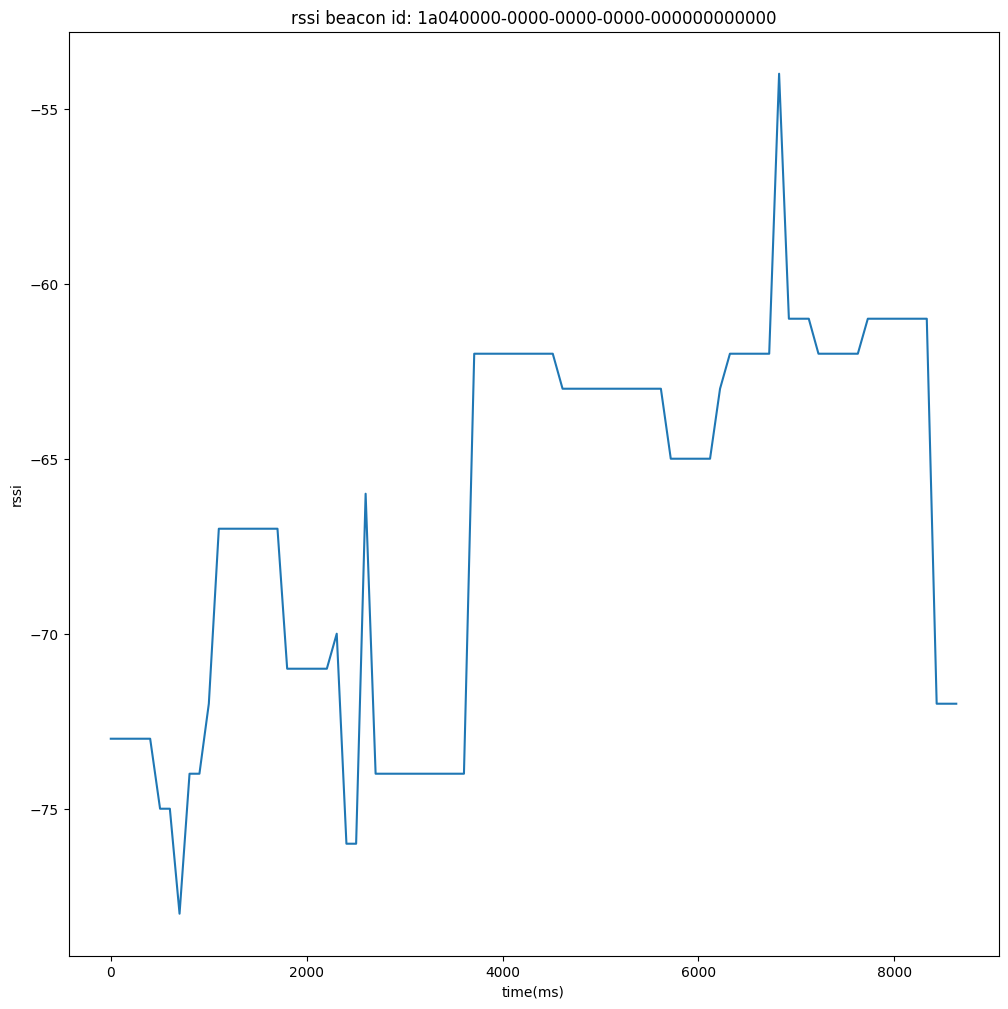

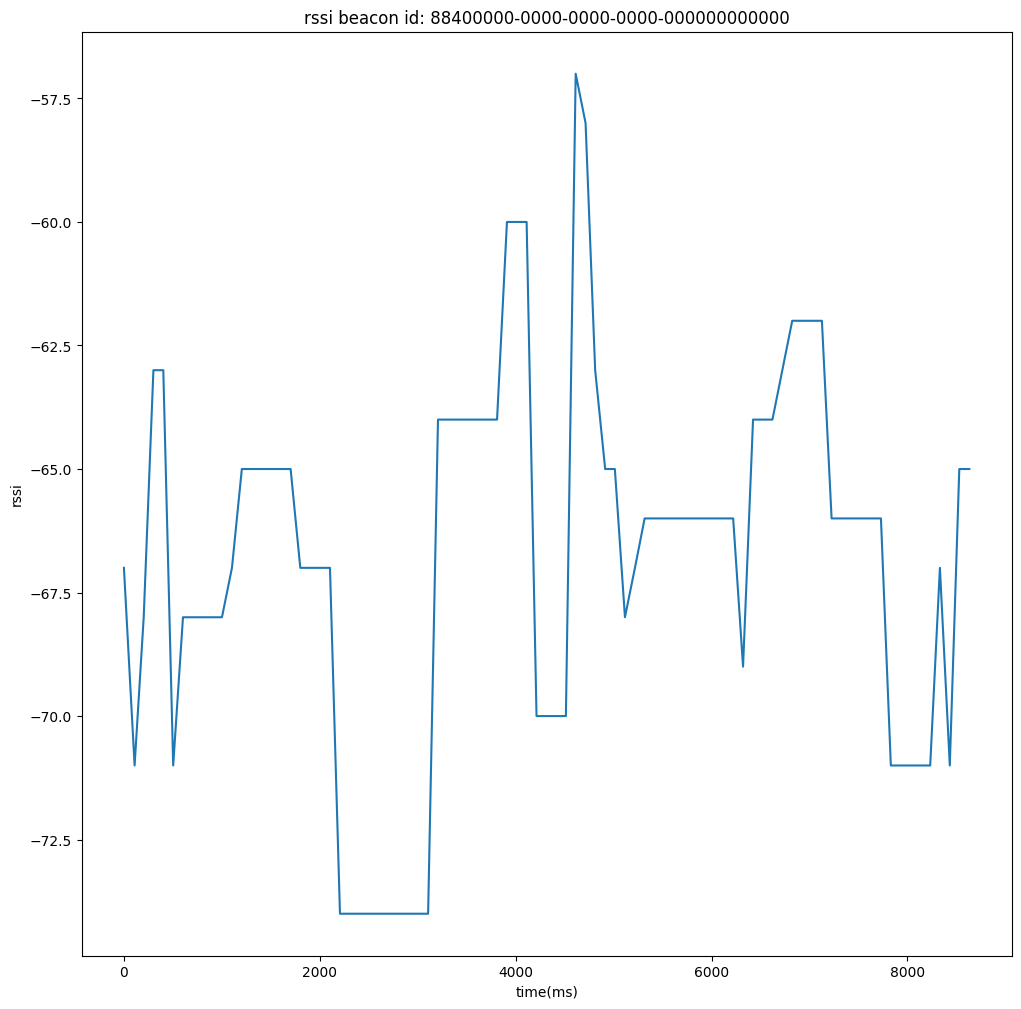

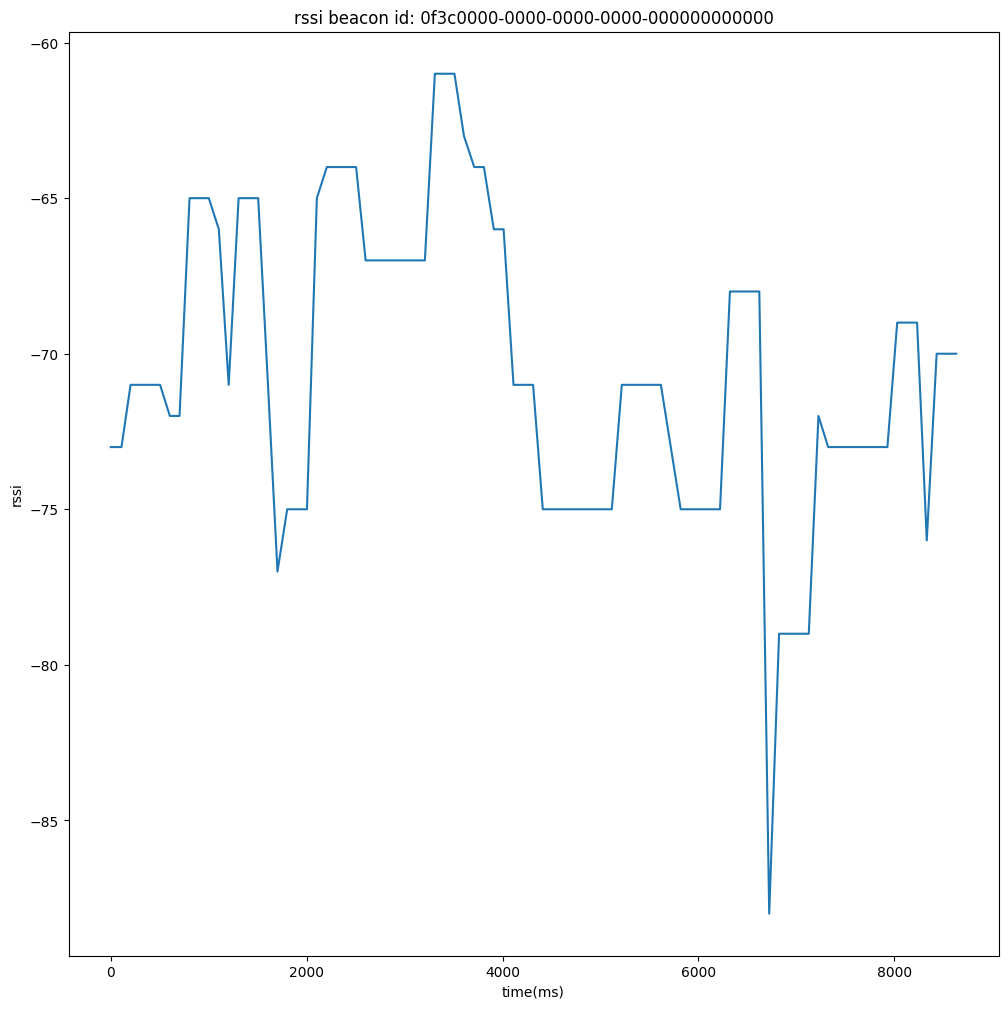

In [8]:

args = argparse.Namespace(beacon_coords_file='../datas/data0905p6/beacon_coords.txt', beacon_data_dir='../datas/data0905p6/', beacon_data_file='../datas/data0905p6/bluetoothData(105).txt', update_frequency=10)

beacon_data = read_beacon_data(args.beacon_data_file)

def remove_outliers(data, threshold=0.5):
    mean = np.mean(data)
    std = np.std(data)
    return [x if abs(x - mean) <= threshold * std else mean for x in data]

def remove_max_min(data):
    sorted_data = sorted(data)
    max_data = sorted_data[-2:]
    min_data = sorted_data[:2]
    mean = np.mean(sorted_data)
    return [x if x not in max_data and x not in min_data else mean for x in data]

def apply_average_filter(data, remove_f, window_size=5):
    filtered_data = data.copy()
    for i in range(len(filtered_data)-window_size+1):
        trimmed_data = remove_f(filtered_data[i:i+window_size])
        filtered_data[i+window_size//2] = np.mean(trimmed_data)
    return filtered_data

def apply_median_filter(data, remove_f, window_size=5):
    filtered_data = data.copy()
    for i in range(len(filtered_data)-window_size+1):
        trimmed_data = remove_f(filtered_data[i:i+window_size])
        filtered_data[i+window_size//2] = np.median(trimmed_data)
    return filtered_data

def apply_kalman_filter(data):
    # data = remove_outliers(data)
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([data[0]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = 0.1
    kf.H = np.array([[1.]])
    kf.F = np.array([[1.]])
    
    filtered_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        filtered_data.append(kf.x[0])
    return filtered_data

def rssi_to_distance(rssi):
    txPower = -55.47
    n = 3.106
    return 10 ** ((txPower - rssi) / (10 * n))



x0, y0 = 3.0, -1.6
v = 0.00056


beacon_id_to_rssi = defaultdict(list)
time_stamp = []
print(beacon_data)
for beacon_group in beacon_data:
    if len(beacon_group) < 3:
        print("beacon group length is less than 3")
        continue
    for beacon in beacon_group:
        beacon_id = beacon['uuid']
        beacon_id_to_rssi[beacon_id].append(beacon['rssi'])
    time_stamp.append(beacon['time'])

time_stamp = np.array(time_stamp) - time_stamp[0]
d1 = np.sqrt(x0**2 + (y0 + v * time_stamp)**2 + 1.0)
d2 = np.sqrt(x0**2 + (6.0 -y0 - v * time_stamp)**2 + 1.0)
d3 = np.sqrt((x0 - 6.0)**2 + (3 - y0 - v * time_stamp)**2 + 1.0)
ds = [d1, d2, d3]
print("total time interval: ", time_stamp[-1] - time_stamp[0])
total_interval = time_stamp[-1] - time_stamp[0]
for i, (beacon_id, rssi_values) in enumerate(beacon_id_to_rssi.items()):
    if len(beacon_group[0]) <= 3:
        print("beacon group length is less than 3")
        continue
    plt.figure(figsize=(12, 12))
    plt.plot(time_stamp, rssi_values)
    plt.xlabel('time(ms)')
    plt.ylabel('rssi')
    plt.title('rssi beacon id: {}'.format(beacon_id))
    plt.show()
    
    # distance = [rssi_to_distance(rssi) for rssi in rssi_values]
    # rssi_median_filtered = apply_median_filter(rssi_values, remove_max_min)
    # rssi_kalman_filtered = apply_kalman_filter(rssi_values)
    # rssi_mean_filtered = apply_average_filter(rssi_values, remove_max_min)
    # plt.figure(figsize=(12, 12))
    # plt.plot(time_stamp, rssi_values, label='rssi')
    # plt.plot(time_stamp, rssi_median_filtered, label='rssi median filter')
    # plt.plot(time_stamp, rssi_kalman_filtered, label='rssi kalman filter')
    # plt.plot(time_stamp, rssi_mean_filtered, label='rssi mean filter')
    # # plt.plot(time_stamp, d, label='real distance')
    # plt.xlabel('time(ms)')
    # plt.ylabel('rssi')
    # plt.legend()
    # plt.title('rssi filtered beacon id: {}'.format(beacon_id))
    # plt.show()
    
    # rssi_median_filtered = apply_median_filter(rssi_values, remove_outliers)
    # rssi_mean_filtered = apply_average_filter(rssi_values, remove_outliers)
    # rssi_kalman_filtered = apply_kalman_filter(rssi_values) 
    # plt.figure(figsize=(12, 12))
    # plt.plot(time_stamp, rssi_values, label='rssi')
    # plt.plot(time_stamp, rssi_median_filtered, label='rssi median filter')
    # plt.plot(time_stamp, rssi_kalman_filtered, label='rssi kalman filter')
    # plt.plot(time_stamp, rssi_mean_filtered, label='rssi mean filter')
    # # plt.plot(time_stamp, d, label='real distance')
    # plt.xlabel('time(ms)')
    # plt.ylabel('rssi')
    # plt.legend()
    # plt.title('rssi filtered beacon id: {}, use std-mean trim method'.format(beacon_id))
    # plt.show() 
    
    
    # distance_median_filtered = [rssi_to_distance(rssi) for rssi in rssi_median_filtered]
    # distance_kalman_filtered = [rssi_to_distance(rssi) for rssi in rssi_kalman_filtered]
    # distance_mean_filtered = [rssi_to_distance(rssi) for rssi in rssi_mean_filtered]
    # plt.figure(figsize=(12, 12))
    # plt.plot(time_stamp, distance, label='rssi to distance')
    # plt.plot(time_stamp, distance_median_filtered, label='distance median filter')
    # plt.plot(time_stamp, distance_kalman_filtered, label='distance kalman filter')
    # plt.plot(time_stamp, distance_mean_filtered, label='distance mean filter')
    # # plt.plot(time_stamp, ds[i], label='real distance')
    # plt.xlabel('time(ms)')
    # plt.ylabel('distance(m)')
    # plt.title('distance filtered beacon id: {}'.format(beacon_id))
    # plt.legend()
    # plt.show()


In [9]:
from utils.common import aggregate_continuous_points_sliding, aggregate_continuous_points
import re


args = argparse.Namespace(beacon_coords_file='../datas/data0905p6/beacon_coords.txt', beacon_data_dir='../datas/data0905p6/', beacon_data_file='', update_frequency=10)

files = []
for file in os.listdir(args.beacon_data_dir):
    if re.match(r'bluetoothData\(\d+\).txt', file):
        files.append(file)

positionss = []
for beacon_data_file in files:
    args.beacon_data_file = args.beacon_data_dir + beacon_data_file
    actual_coords = read_beacon_coords(args.beacon_coords_file)
    beacon_data = read_beacon_data(args.beacon_data_file)
    print("beacon data",beacon_data)
    print("beacon group num", len(beacon_data))
    print("beacon data file", args.beacon_data_file)

    positions = process_beacon_data_for_pos(args)
    positions = [pos[:3] for pos in positions if pos is not None]
    positionss.append(positions)

beacon data [[{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -76, 'accuracy': 89.57094250551359, 'time': 1725523847318}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -71, 'accuracy': 45.78640352029778, 'time': 1725523847318}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -76, 'accuracy': 89.57094250551359, 'time': 1725523847415}, {'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -69, 'accuracy': 34.59438414037775, 'time': 1725523847415}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -71, 'accuracy': 45.78640352029778, 'time': 1725523847415}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -76, 'accuracy': 89.57094250551359, 'time': 1725523847516}, {'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -71, 'accuracy': 45.78640352029778, 'time': 1725523847516}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -74, 'accuracy': 68.82791240399628, 'time': 1725523847516}], [{'uuid': '1a040000-0000-0000-0000-0000000000

len positions 88
positions [array([[2.09745496],
       [1.6256862 ],
       [0.81891908]]), array([[2.077013  ],
       [1.76640883],
       [0.96714509]]), array([[2.46953113],
       [1.92417722],
       [0.94444112]]), array([[2.4475287 ],
       [1.82410353],
       [0.92871821]]), array([[2.42451493],
       [1.75192733],
       [0.91724159]]), array([[2.59583795],
       [1.50012239],
       [0.90936097]]), array([[2.70430718],
       [1.33672477],
       [0.90426549]]), array([[2.79717185],
       [1.25098762],
       [0.90105993]]), array([[2.12270626],
       [0.8502532 ],
       [0.98046607]]), array([[2.45925535],
       [0.79190901],
       [0.95432727]]), array([[2.68677918],
       [0.75947608],
       [0.93629649]]), array([[2.83985572],
       [0.74402199],
       [0.92383889]]), array([[2.94249714],
       [0.73872568],
       [0.91522588]]), array([[3.27696019],
       [0.84780573],
       [0.90926638]]), array([[3.00861401],
       [1.35360067],
       [0.90515738]]

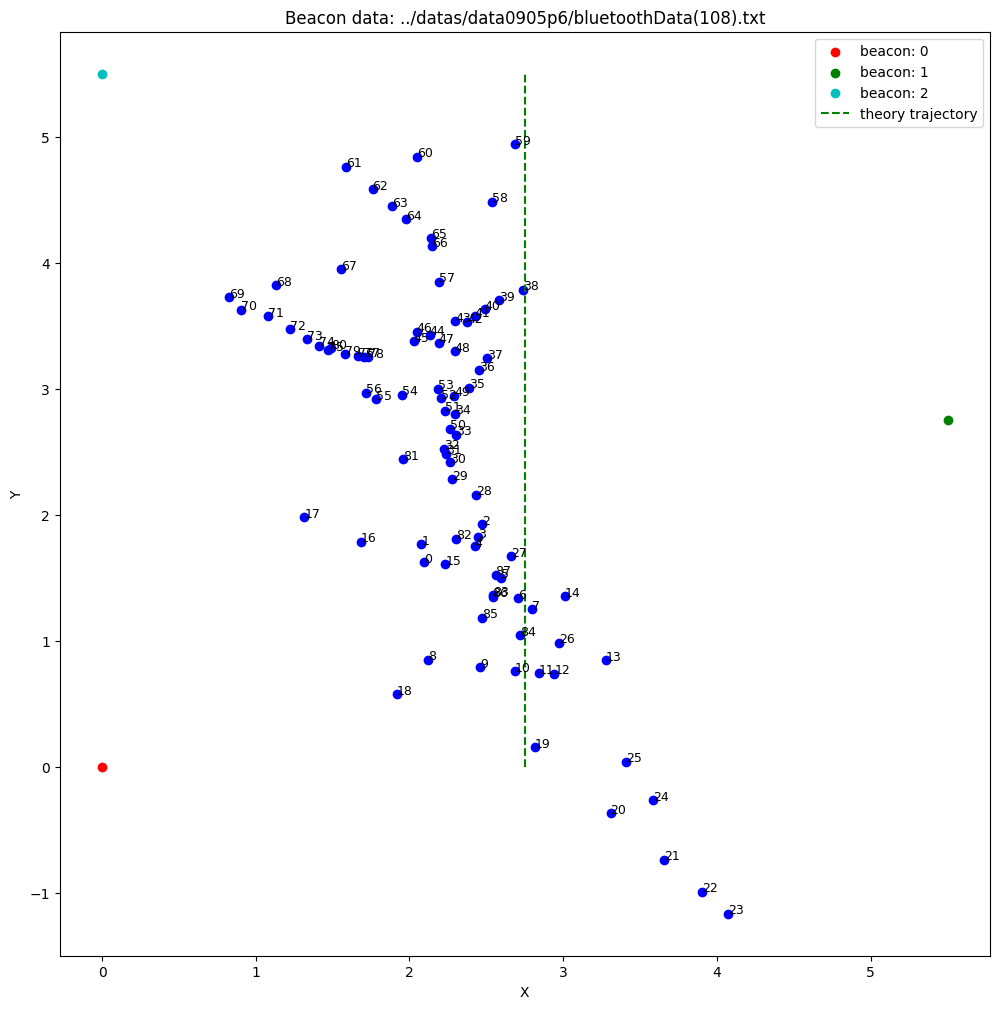

positions [array([[2.09745496],
       [1.6256862 ],
       [0.81891908]]), array([[2.077013  ],
       [1.76640883],
       [0.96714509]]), array([[2.46953113],
       [1.92417722],
       [0.94444112]]), array([[2.4475287 ],
       [1.82410353],
       [0.92871821]]), array([[2.42451493],
       [1.75192733],
       [0.91724159]]), array([[2.59583795],
       [1.50012239],
       [0.90936097]]), array([[2.70430718],
       [1.33672477],
       [0.90426549]]), array([[2.79717185],
       [1.25098762],
       [0.90105993]]), array([[2.12270626],
       [0.8502532 ],
       [0.98046607]]), array([[2.45925535],
       [0.79190901],
       [0.95432727]]), array([[2.68677918],
       [0.75947608],
       [0.93629649]]), array([[2.83985572],
       [0.74402199],
       [0.92383889]]), array([[2.94249714],
       [0.73872568],
       [0.91522588]]), array([[3.27696019],
       [0.84780573],
       [0.90926638]]), array([[3.00861401],
       [1.35360067],
       [0.90515738]]), array([[2.2321

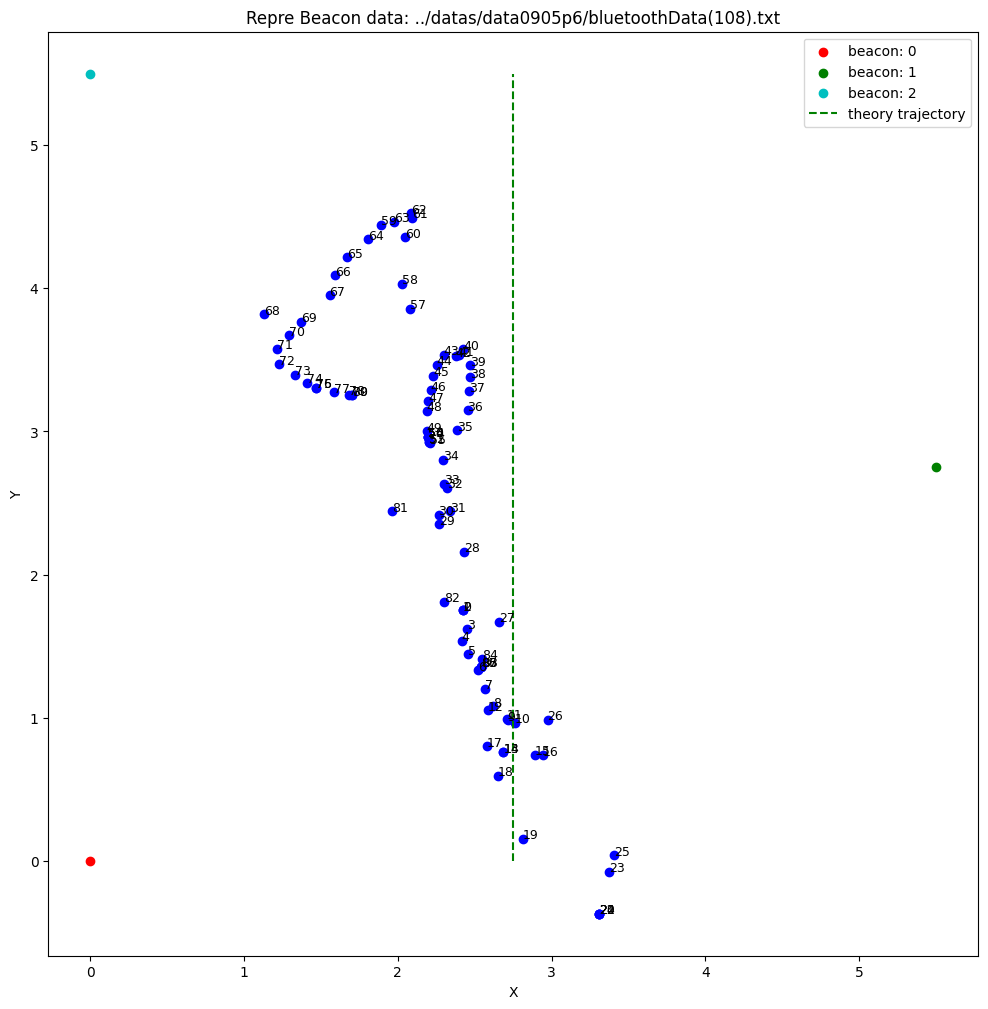

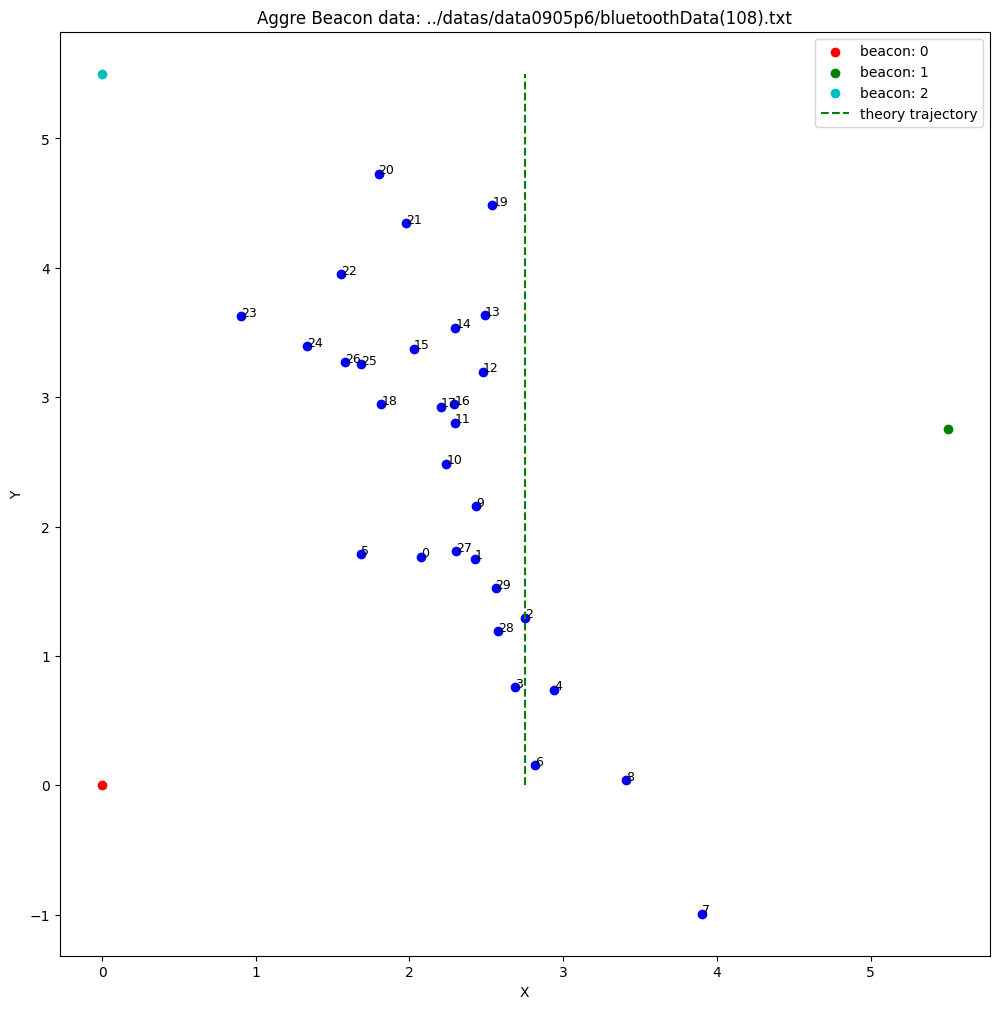

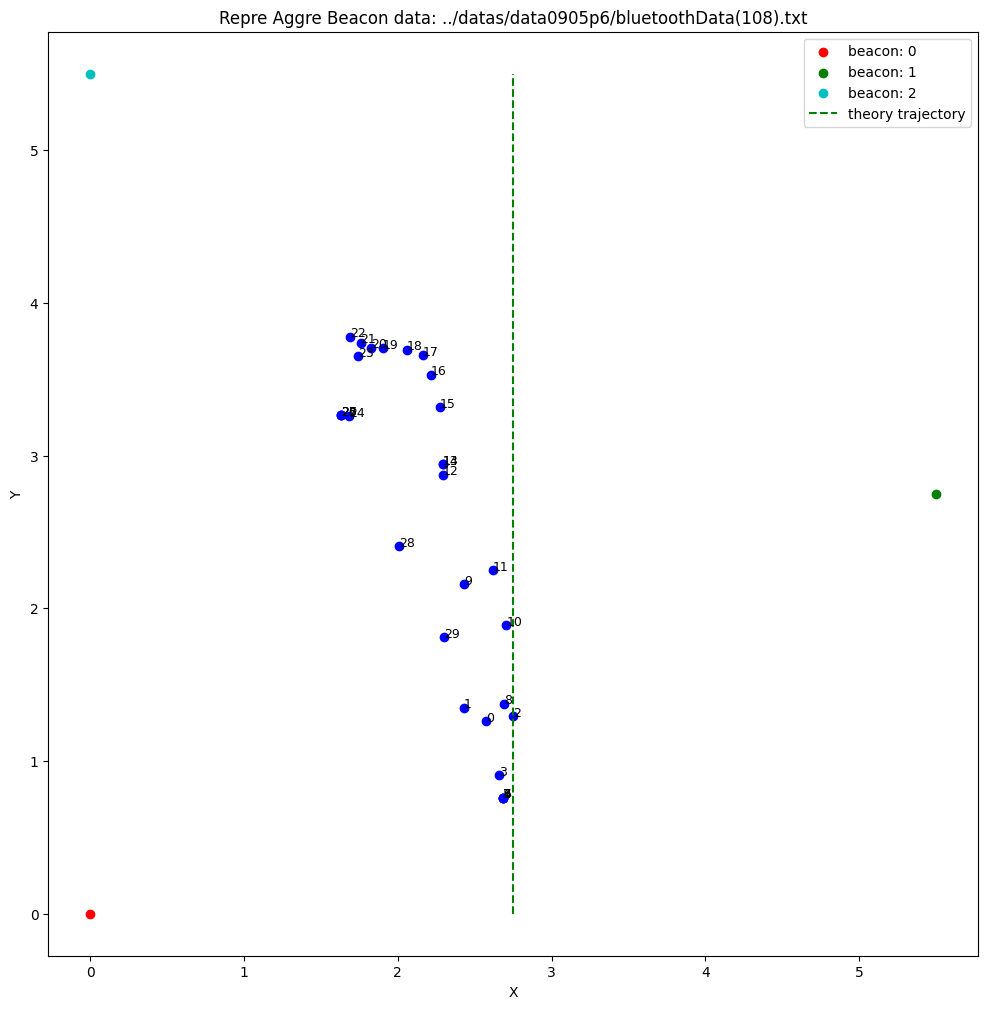

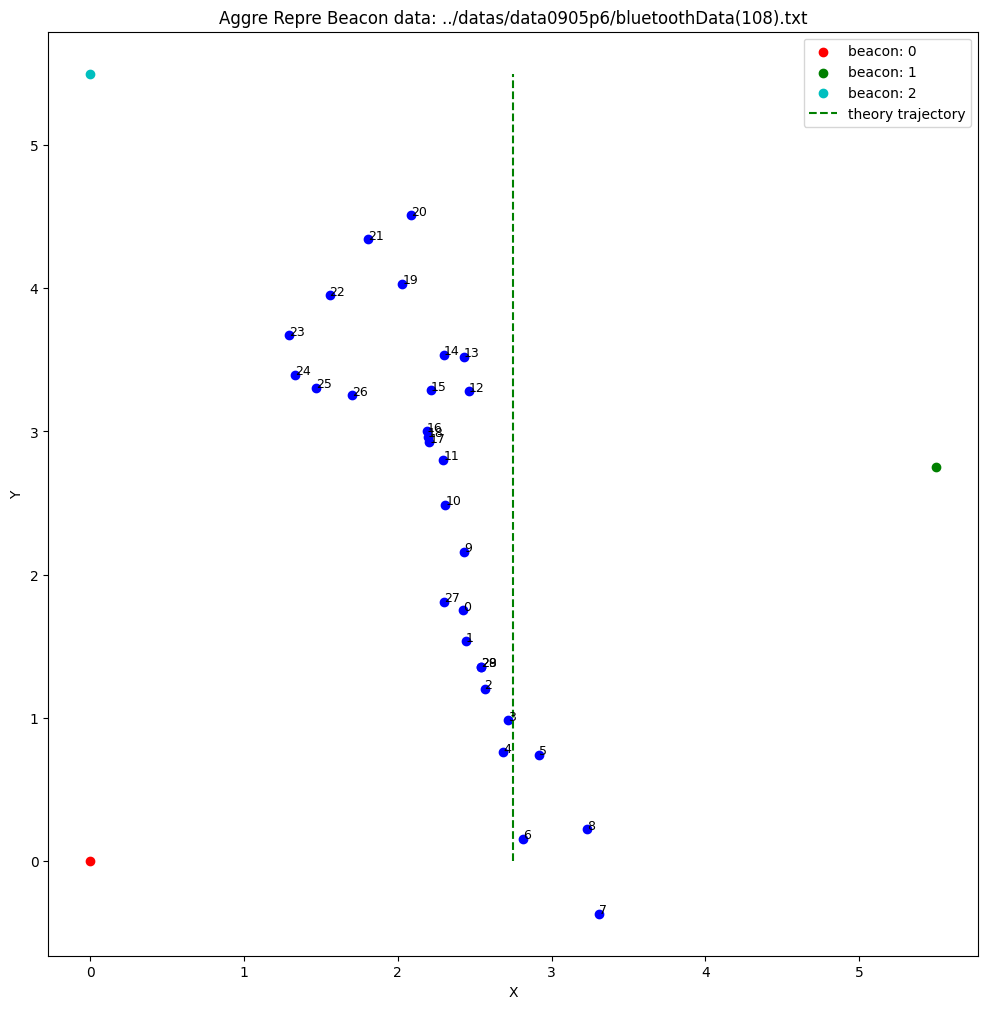

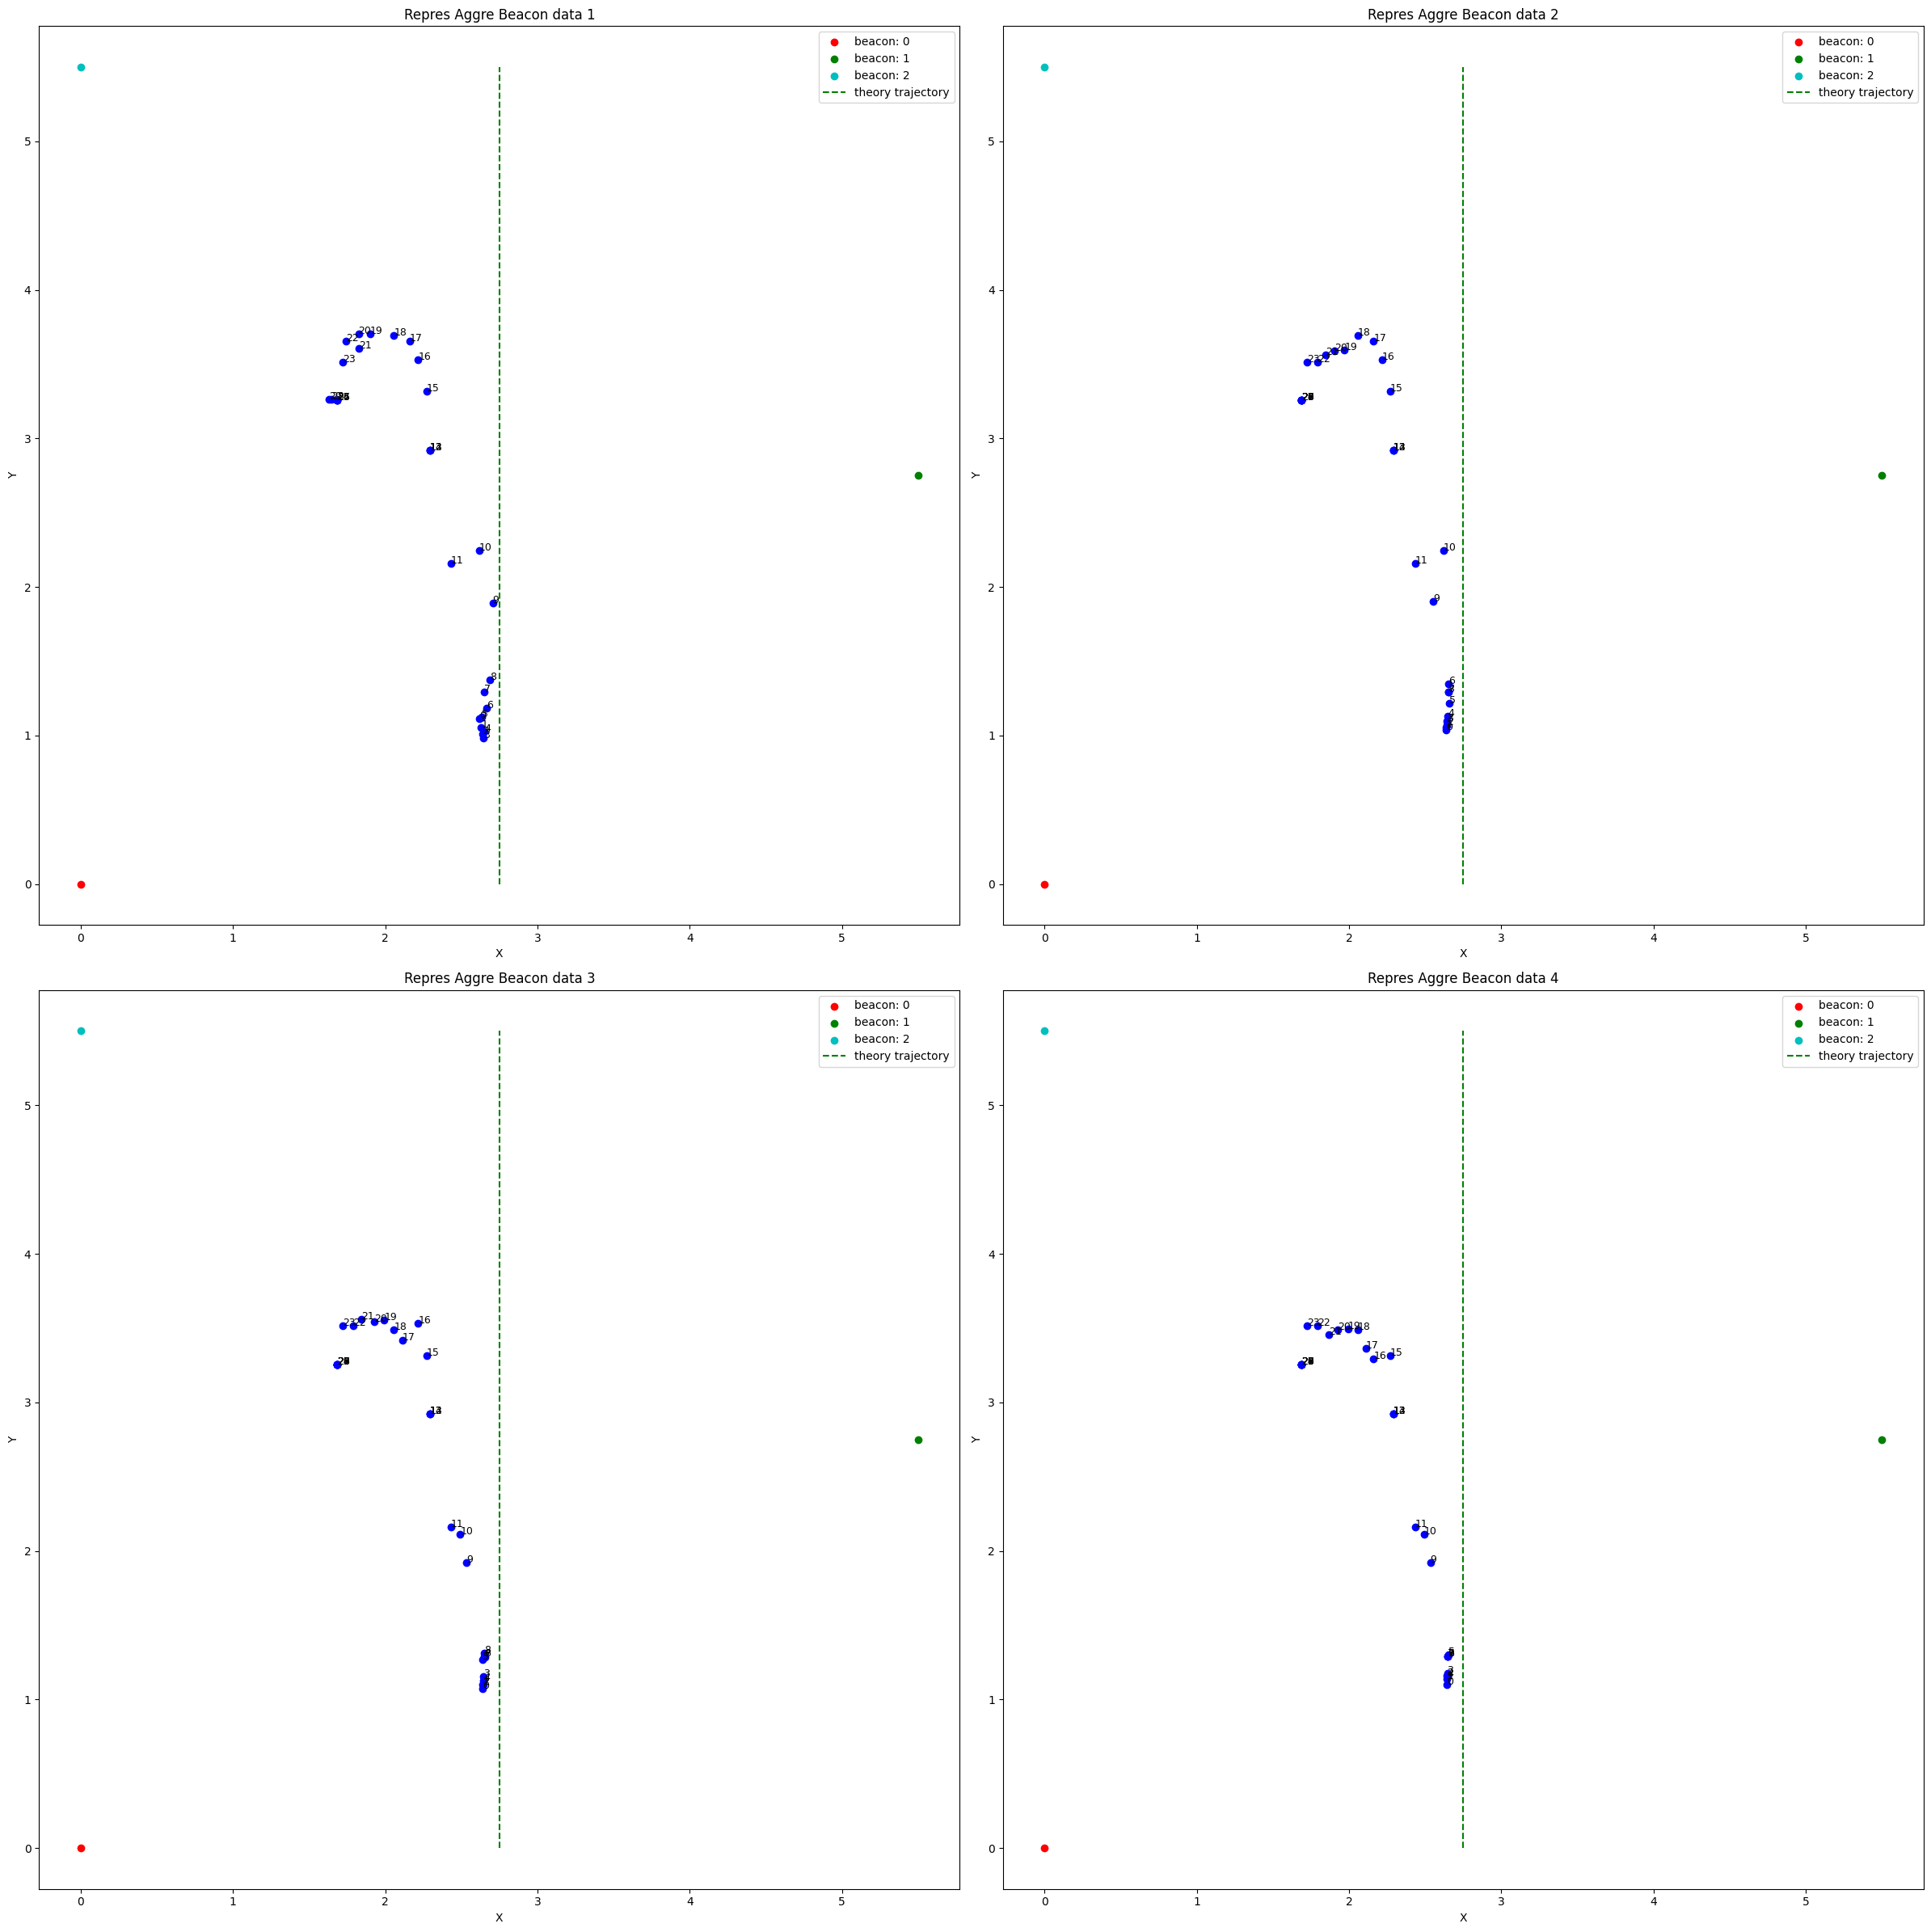

len positions 88
positions [array([[2.09745479],
       [1.62568607],
       [0.81891901]]), array([[2.07698061],
       [1.76636324],
       [0.96711199]]), array([[2.46941756],
       [1.92409038],
       [0.94440245]]), array([[2.44760217],
       [1.82391242],
       [0.92866371]]), array([[2.4243817 ],
       [1.75160346],
       [0.91716353]]), array([[2.59570793],
       [1.49973889],
       [0.90928828]]), array([[2.70456444],
       [1.33593238],
       [0.90418755]]), array([[2.79726163],
       [1.25045445],
       [0.9009976 ]]), array([[2.12257469],
       [0.84991594],
       [0.98042463]]), array([[2.45907155],
       [0.79178494],
       [0.95428929]]), array([[2.68650262],
       [0.75944876],
       [0.9362698 ]]), array([[2.8399461 ],
       [0.74350251],
       [0.92381252]]), array([[2.94303946],
       [0.73785434],
       [0.91518416]]), array([[3.27834267],
       [0.8472561 ],
       [0.90921306]]), array([[3.00912501],
       [1.35447115],
       [0.90509931]]

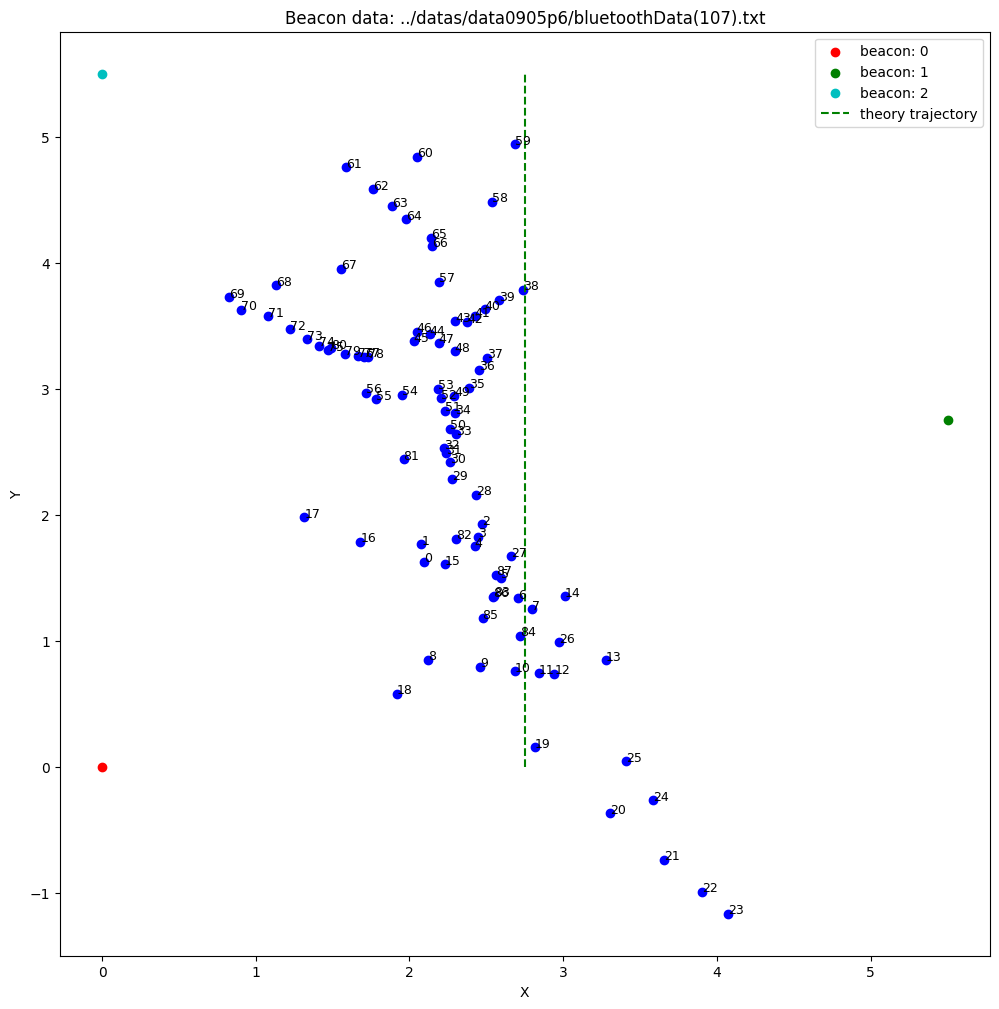

positions [array([[2.09745479],
       [1.62568607],
       [0.81891901]]), array([[2.07698061],
       [1.76636324],
       [0.96711199]]), array([[2.46941756],
       [1.92409038],
       [0.94440245]]), array([[2.44760217],
       [1.82391242],
       [0.92866371]]), array([[2.4243817 ],
       [1.75160346],
       [0.91716353]]), array([[2.59570793],
       [1.49973889],
       [0.90928828]]), array([[2.70456444],
       [1.33593238],
       [0.90418755]]), array([[2.79726163],
       [1.25045445],
       [0.9009976 ]]), array([[2.12257469],
       [0.84991594],
       [0.98042463]]), array([[2.45907155],
       [0.79178494],
       [0.95428929]]), array([[2.68650262],
       [0.75944876],
       [0.9362698 ]]), array([[2.8399461 ],
       [0.74350251],
       [0.92381252]]), array([[2.94303946],
       [0.73785434],
       [0.91518416]]), array([[3.27834267],
       [0.8472561 ],
       [0.90921306]]), array([[3.00912501],
       [1.35447115],
       [0.90509931]]), array([[2.2312

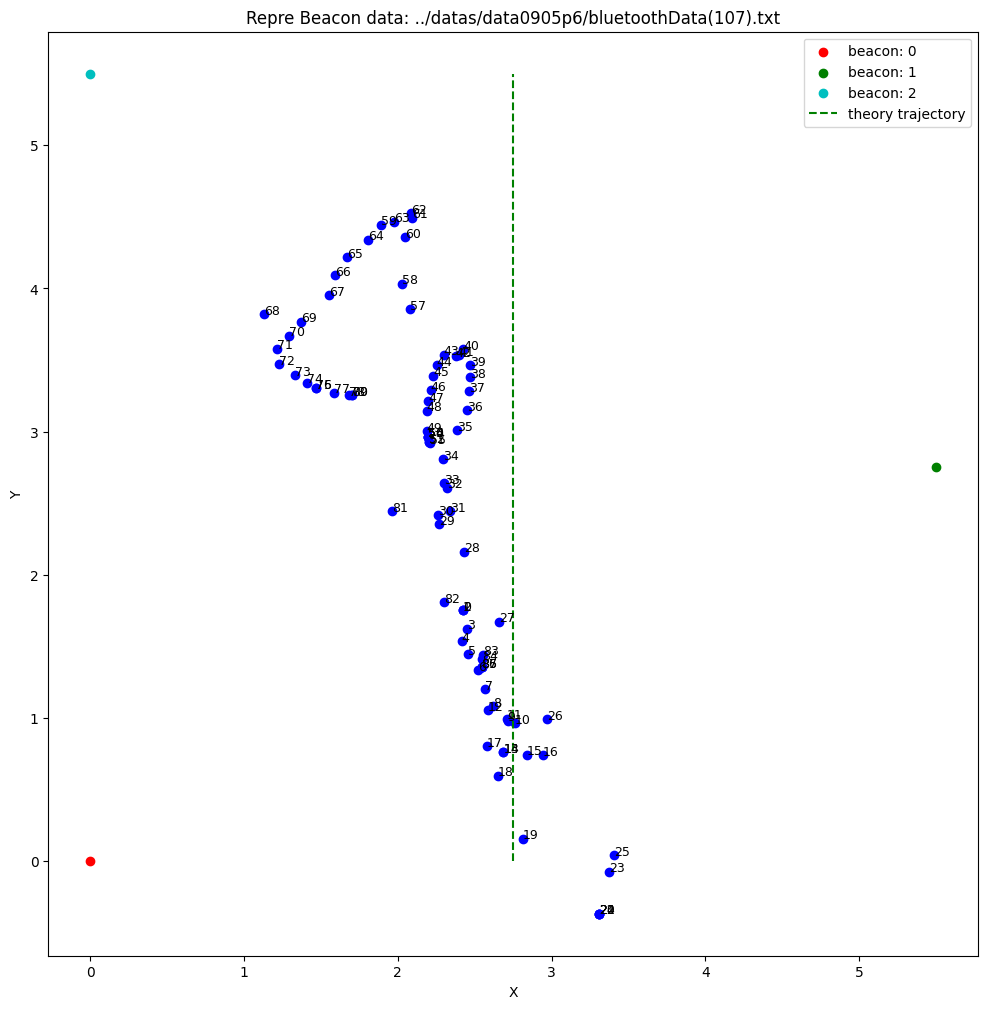

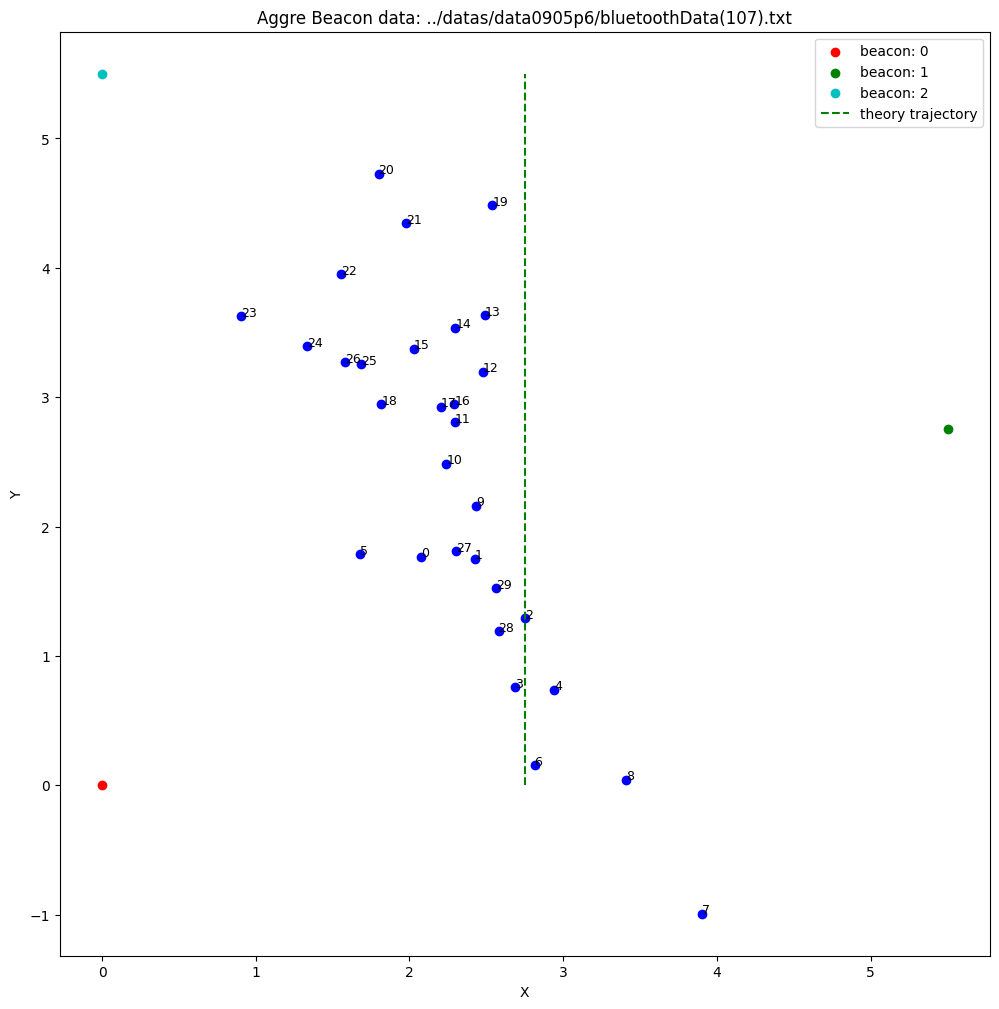

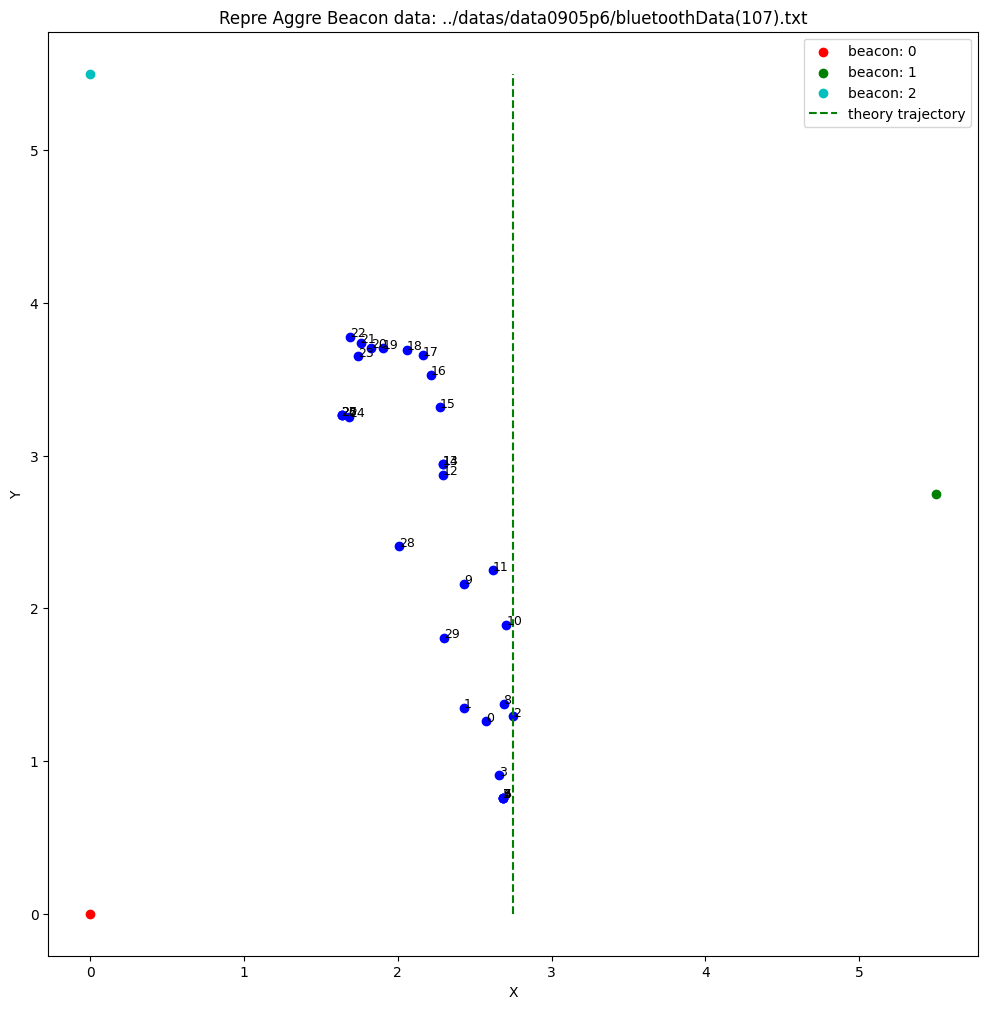

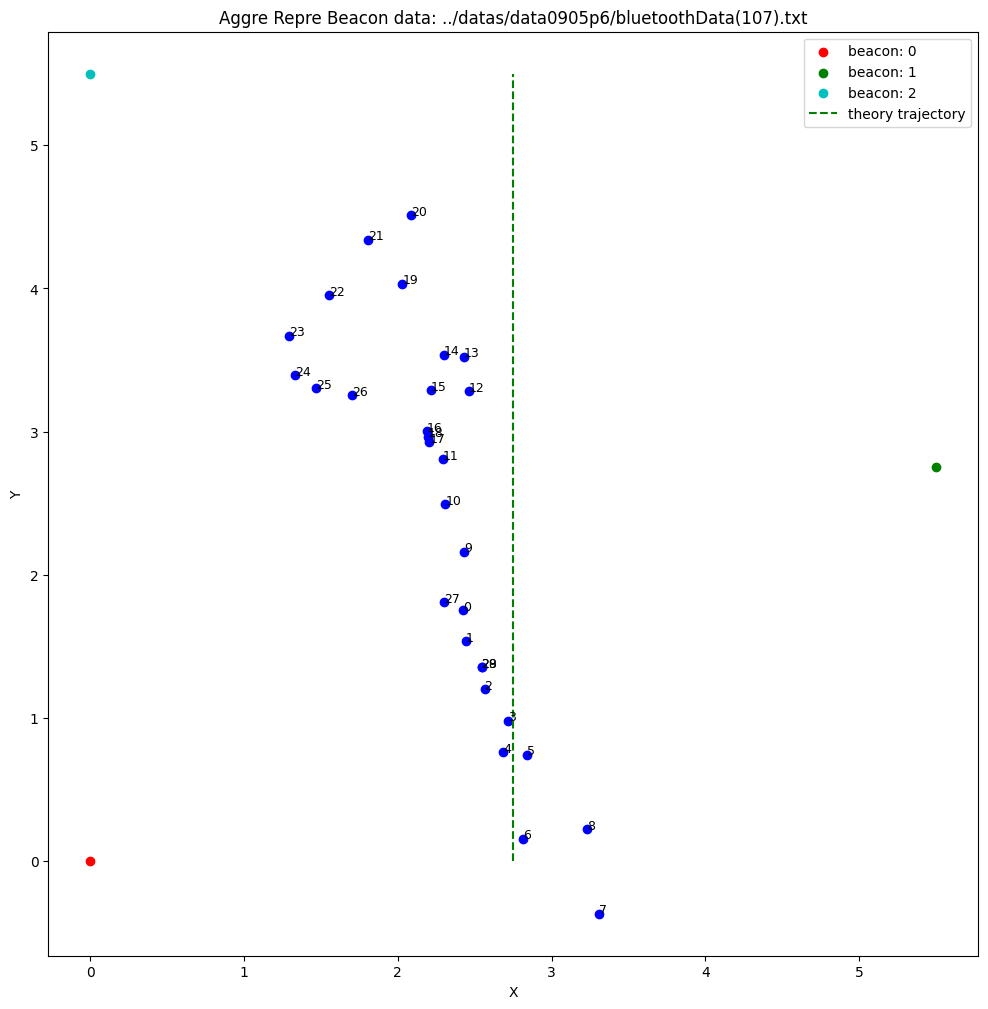

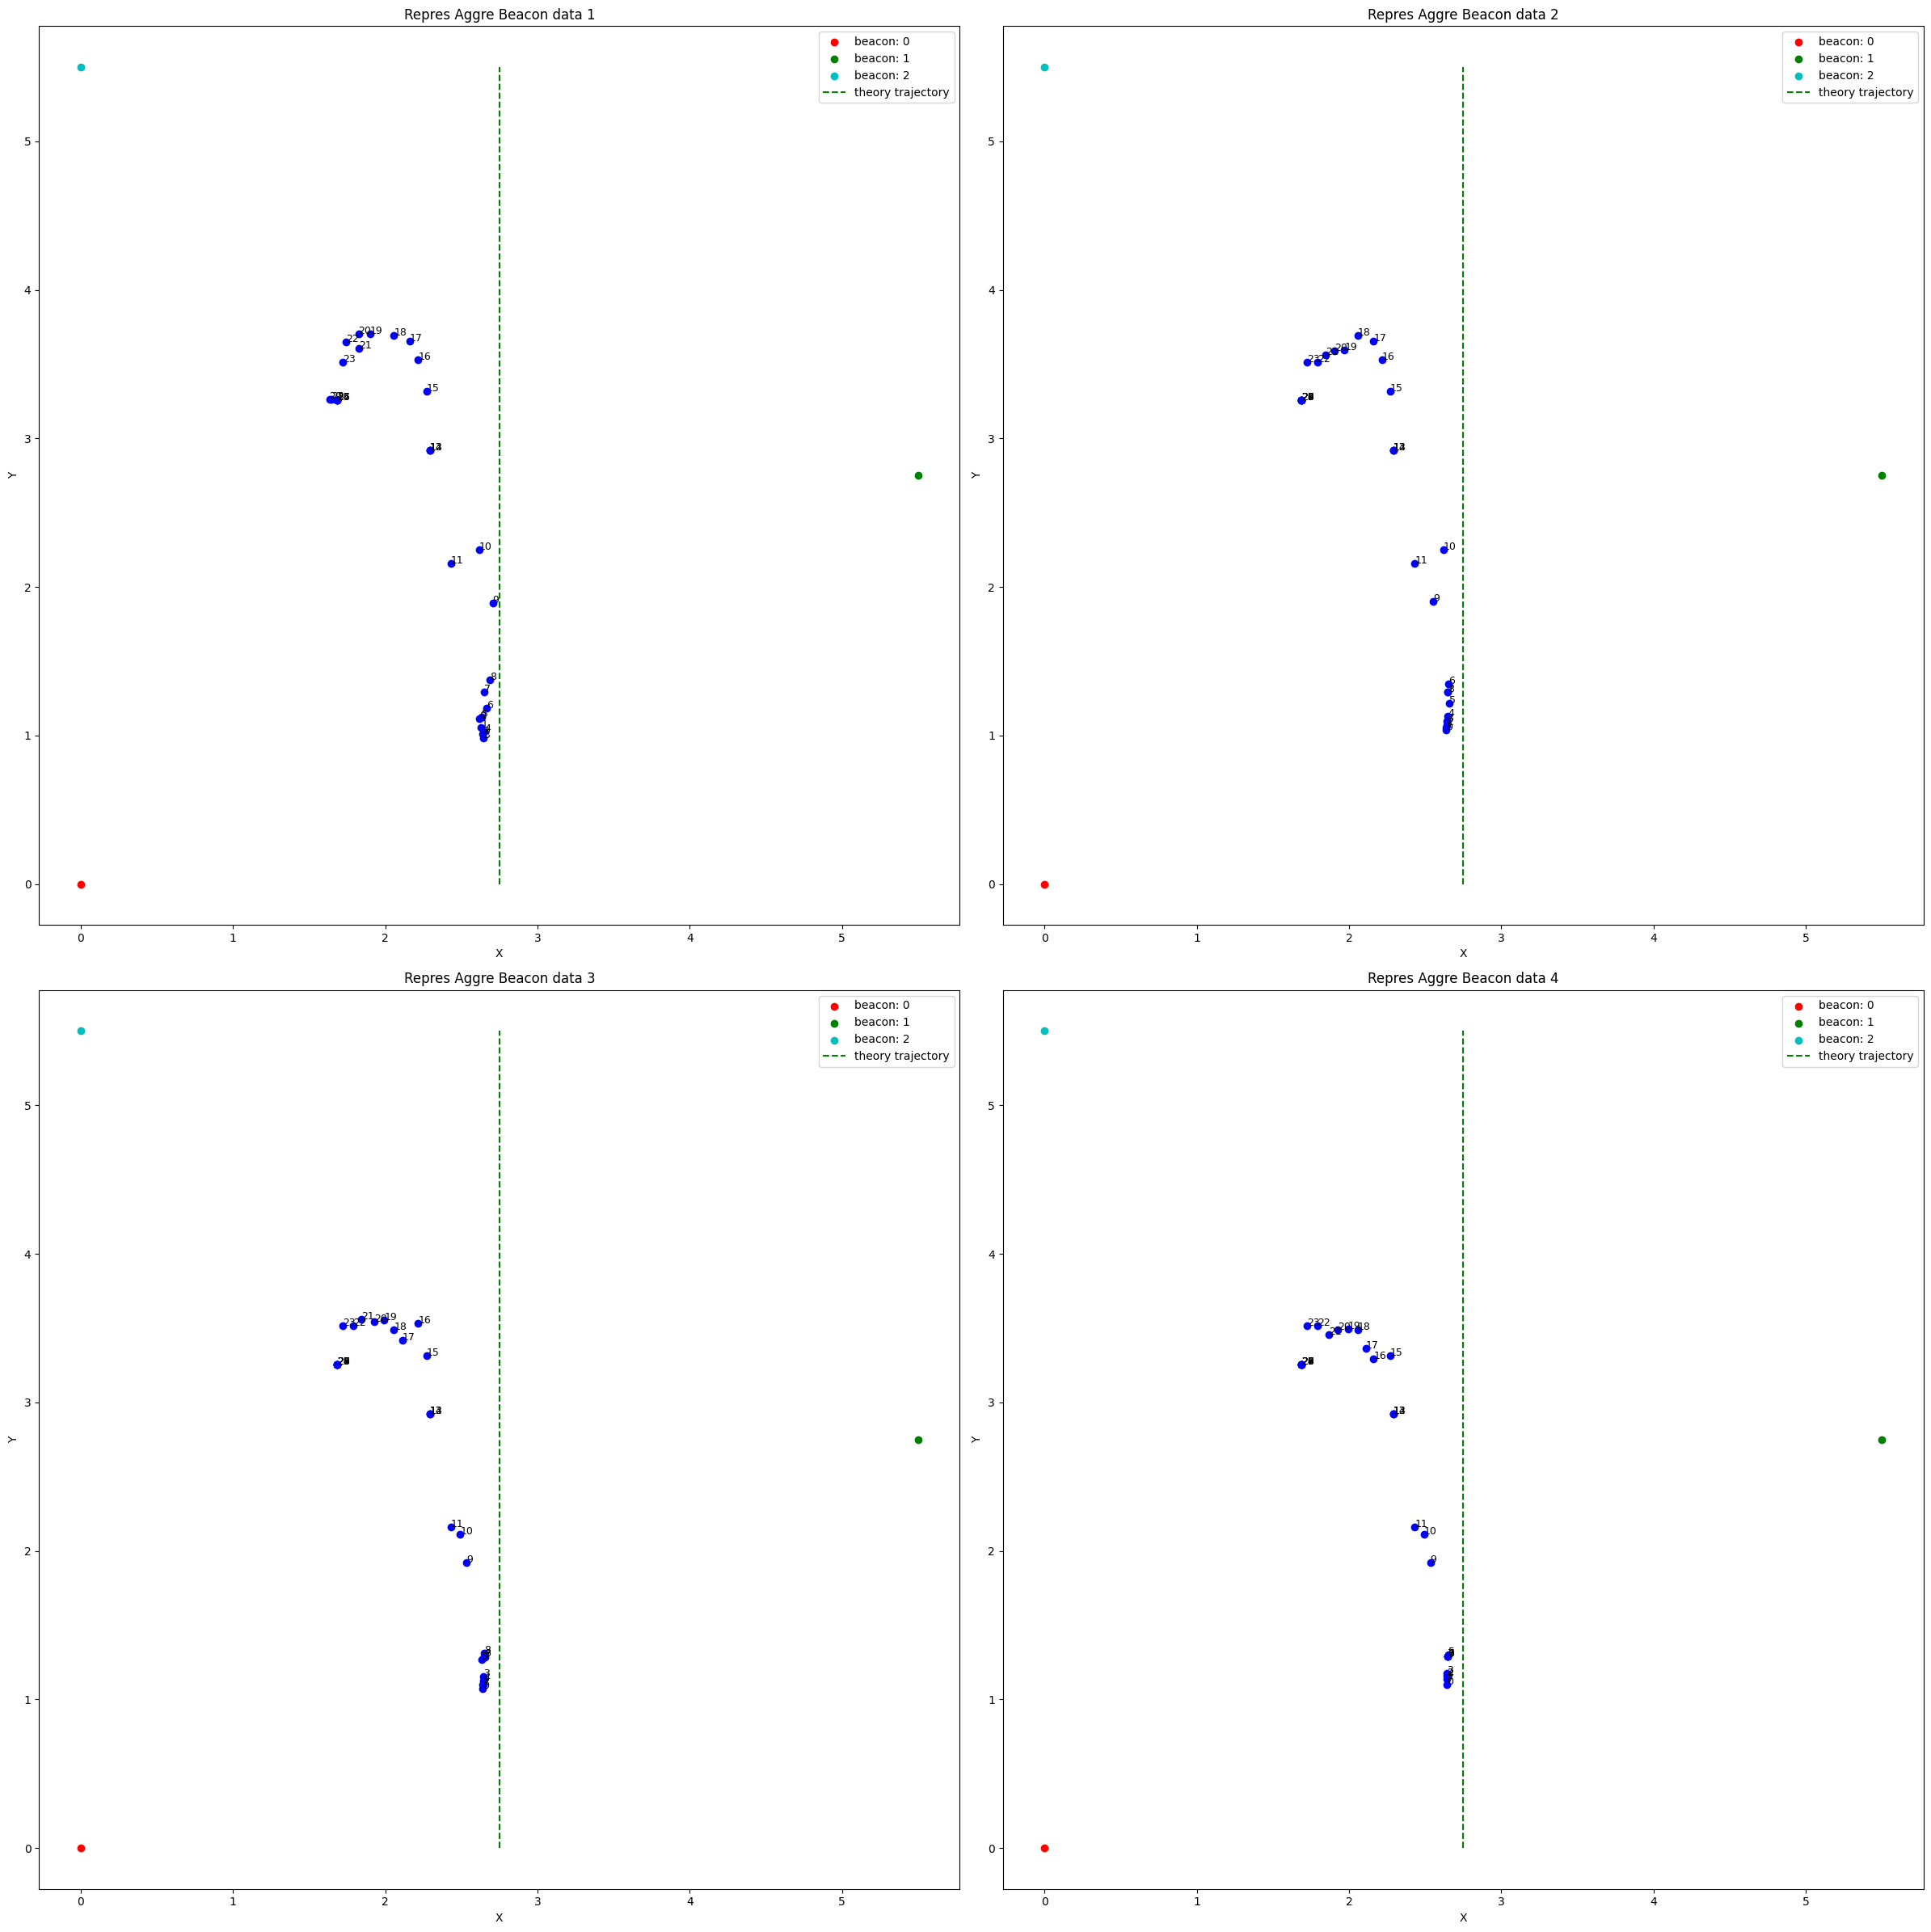

len positions 76
positions [array([[2.33523826],
       [1.87817013],
       [0.81891921]]), array([[2.007699  ],
       [2.14141141],
       [0.96731356]]), array([[2.03079055],
       [2.26343419],
       [1.03538473]]), array([[2.21610456],
       [2.21558238],
       [0.9881264 ]]), array([[2.4798446 ],
       [2.21136795],
       [0.95348695]]), array([[2.51664063],
       [2.17340085],
       [0.92966041]]), array([[2.44986456],
       [2.05405499],
       [0.9141198 ]]), array([[2.40158034],
       [1.97573977],
       [0.90432906]]), array([[2.43796449],
       [2.04276739],
       [0.89832571]]), array([[2.34393433],
       [2.03660141],
       [0.89477637]]), array([[2.3892555 ],
       [1.38999031],
       [0.89275531]]), array([[2.41923703],
       [0.95229161],
       [0.89174265]]), array([[2.43882562],
       [0.65751335],
       [0.89136826]]), array([[3.09229133],
       [0.53953104],
       [0.96330606]]), array([[3.14628021],
       [0.41098625],
       [0.94273545]]

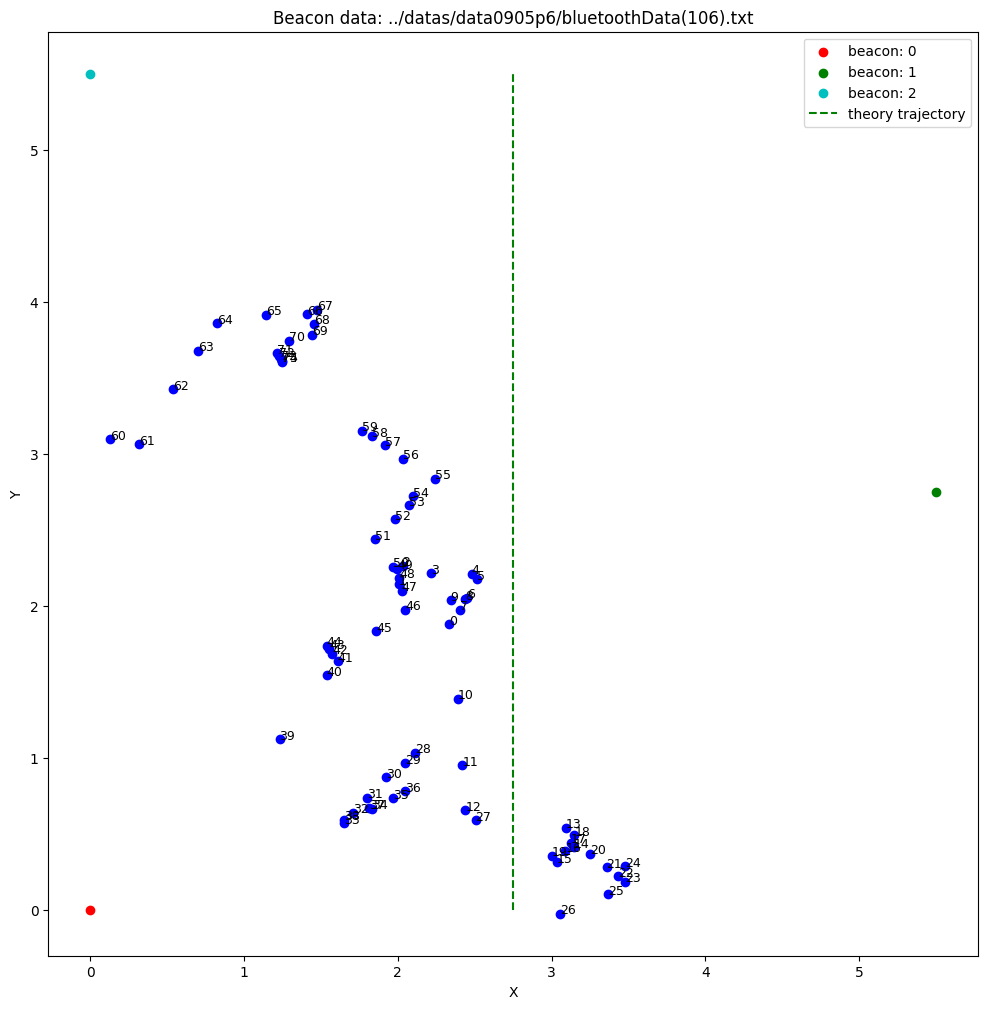

positions [array([[2.33523826],
       [1.87817013],
       [0.81891921]]), array([[2.007699  ],
       [2.14141141],
       [0.96731356]]), array([[2.03079055],
       [2.26343419],
       [1.03538473]]), array([[2.21610456],
       [2.21558238],
       [0.9881264 ]]), array([[2.4798446 ],
       [2.21136795],
       [0.95348695]]), array([[2.51664063],
       [2.17340085],
       [0.92966041]]), array([[2.44986456],
       [2.05405499],
       [0.9141198 ]]), array([[2.40158034],
       [1.97573977],
       [0.90432906]]), array([[2.43796449],
       [2.04276739],
       [0.89832571]]), array([[2.34393433],
       [2.03660141],
       [0.89477637]]), array([[2.3892555 ],
       [1.38999031],
       [0.89275531]]), array([[2.41923703],
       [0.95229161],
       [0.89174265]]), array([[2.43882562],
       [0.65751335],
       [0.89136826]]), array([[3.09229133],
       [0.53953104],
       [0.96330606]]), array([[3.14628021],
       [0.41098625],
       [0.94273545]]), array([[3.0347

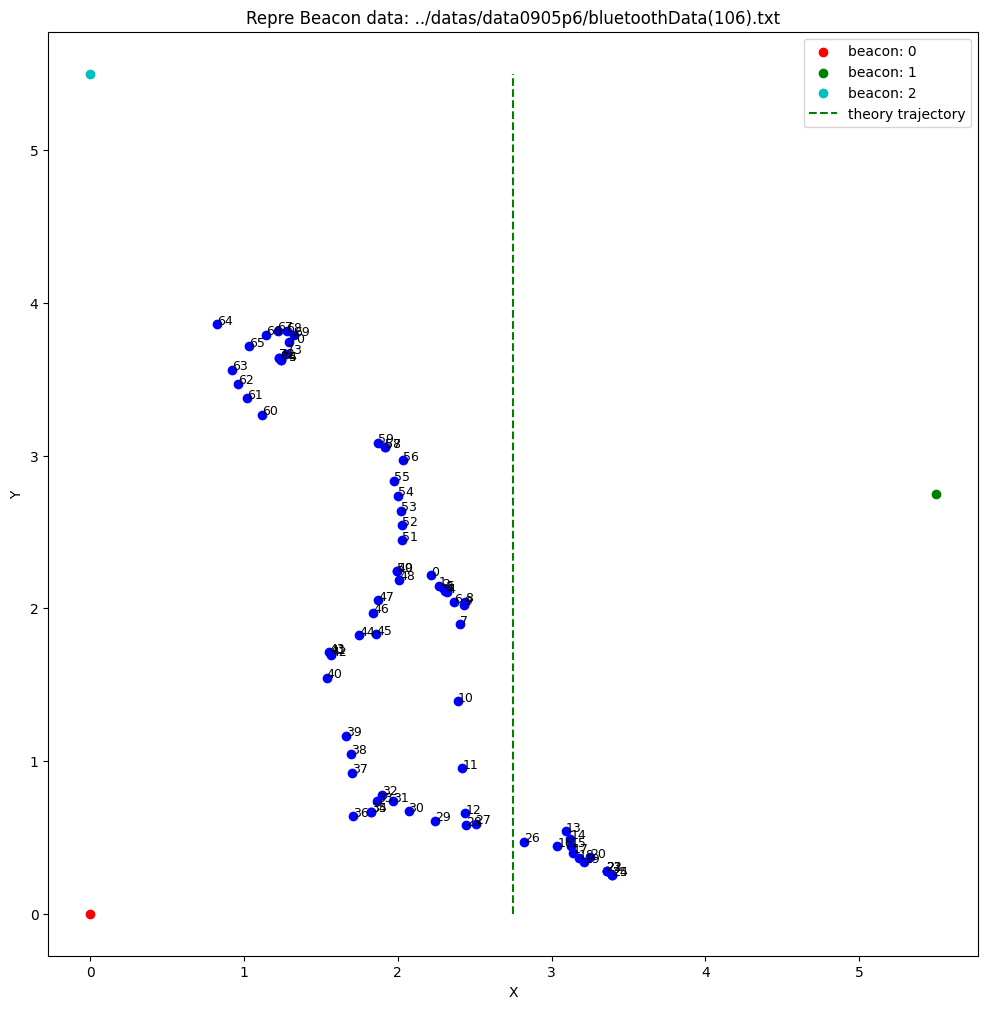

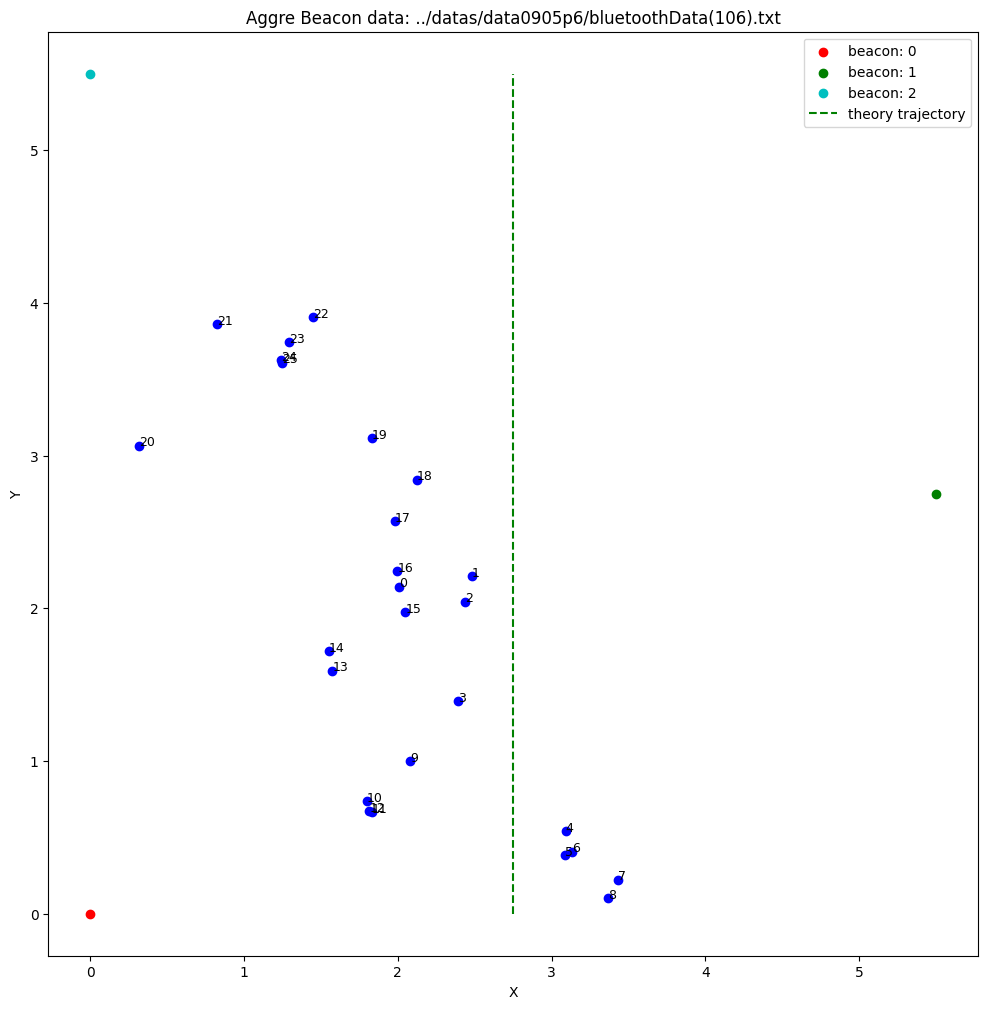

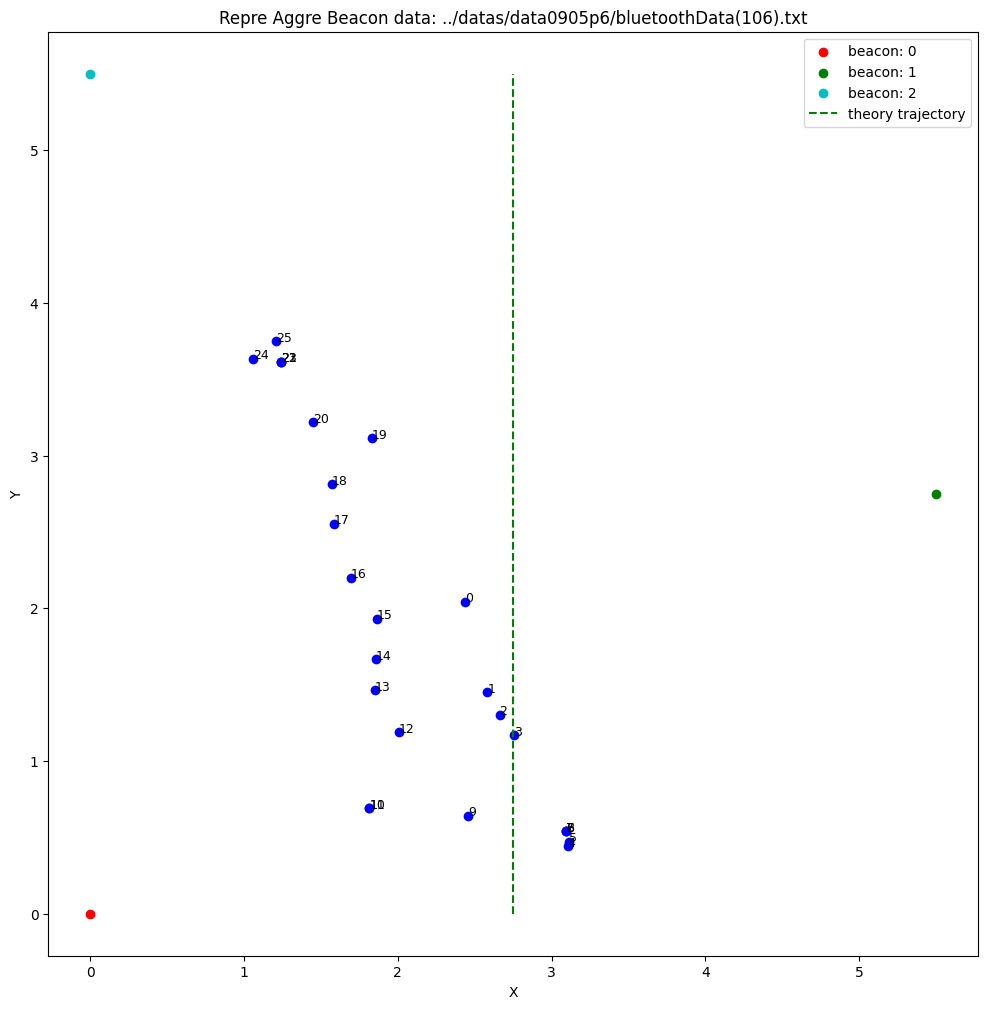

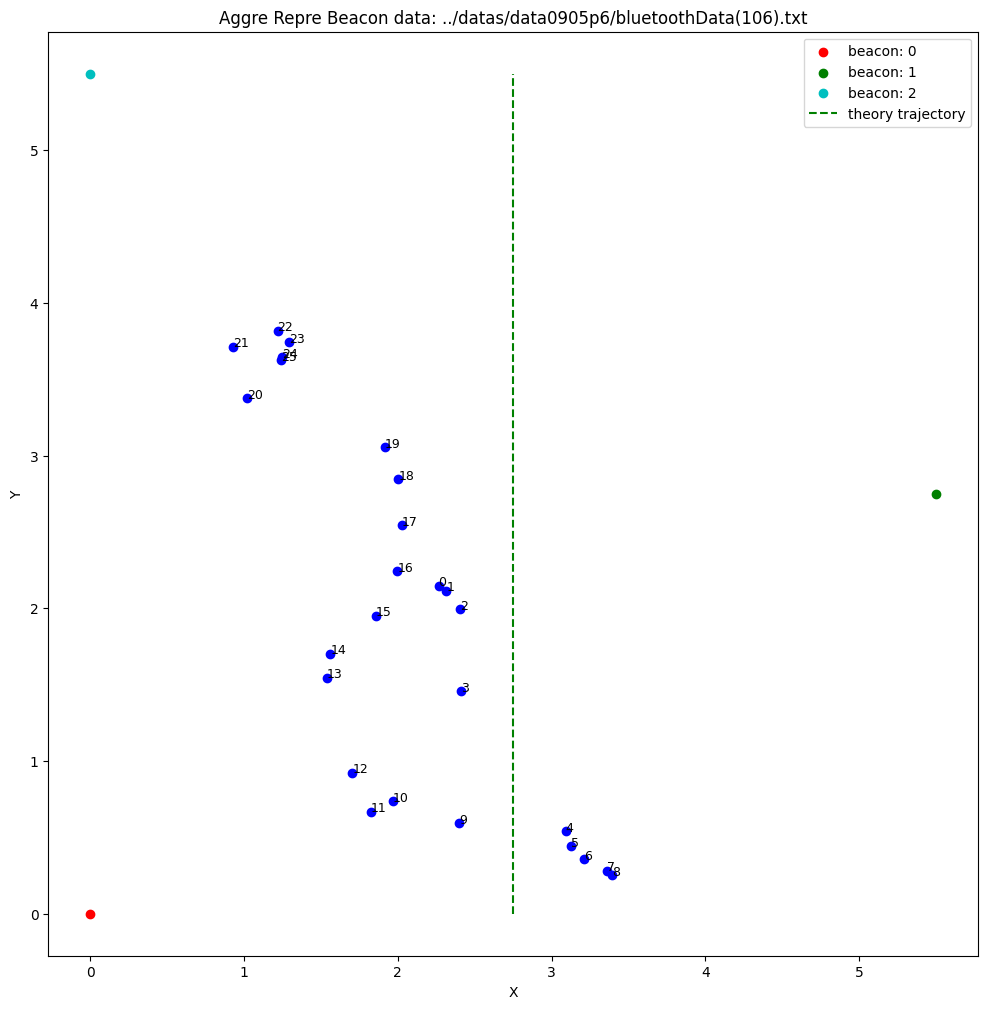

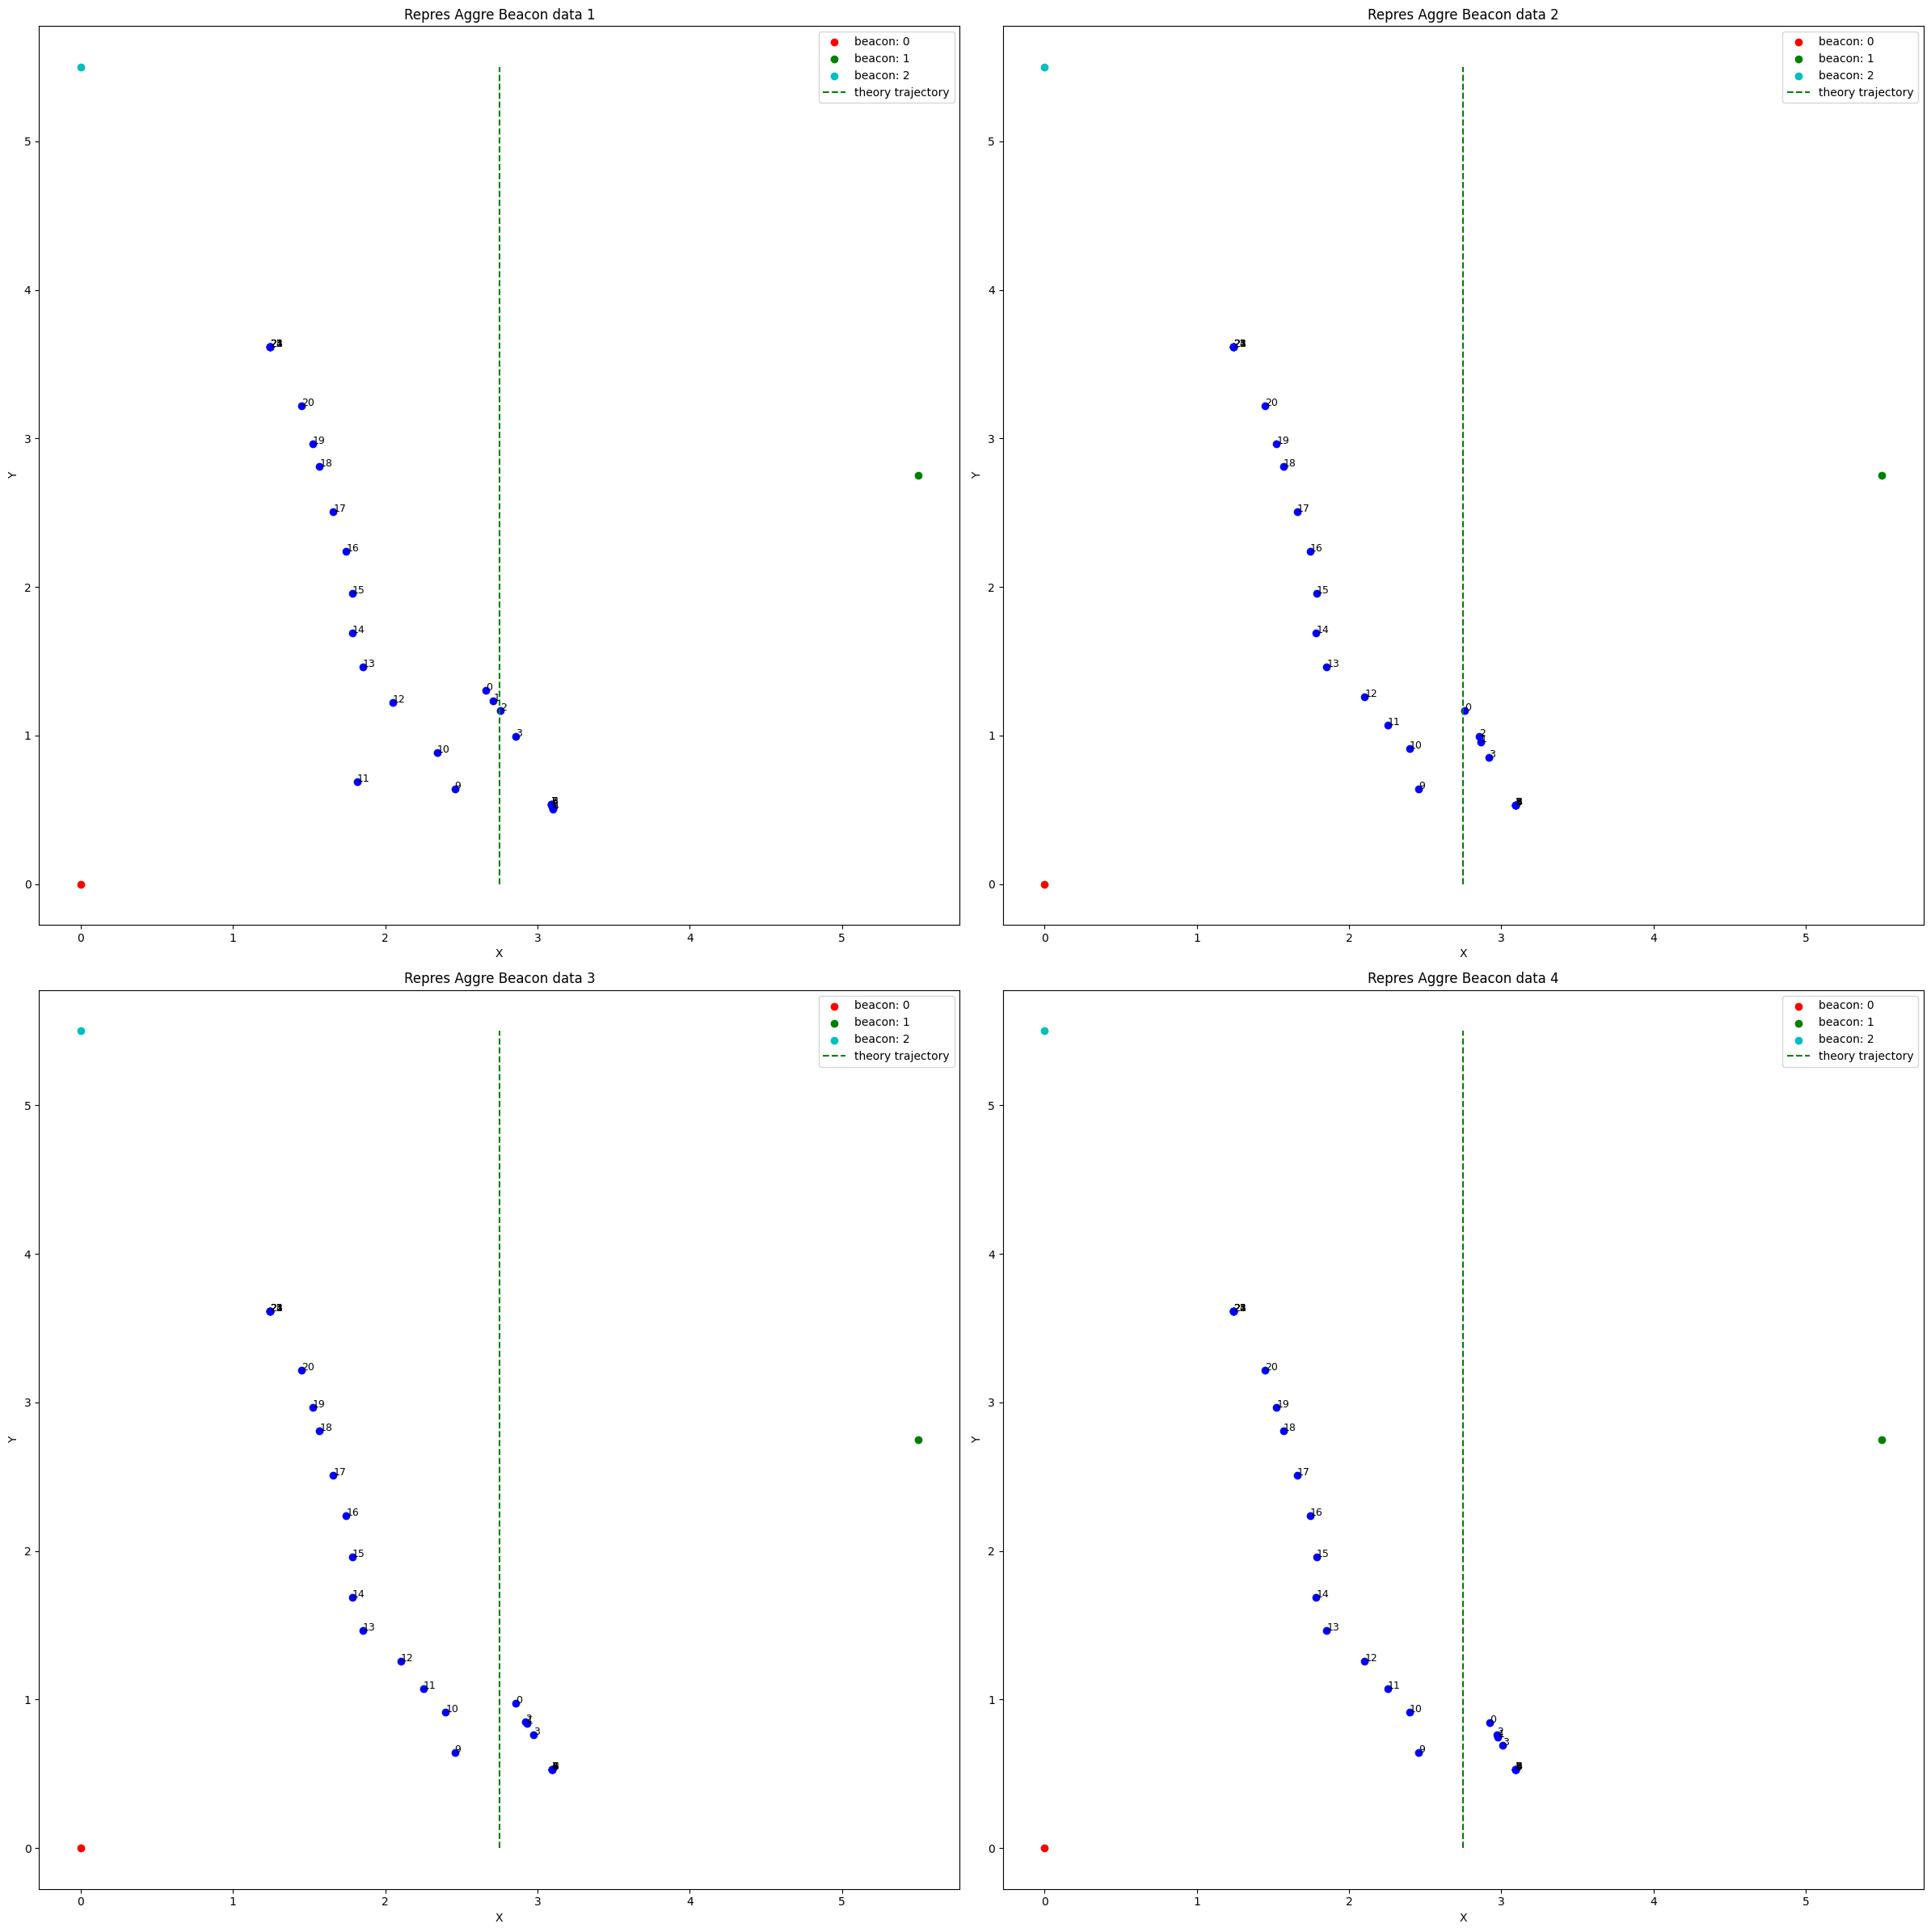

len positions 87
positions [array([[1.51182679],
       [1.92978595],
       [0.81891898]]), array([[1.71644418],
       [2.22192749],
       [0.86168518]]), array([[1.84013839],
       [2.23558176],
       [0.88122798]]), array([[1.81255049],
       [2.10885426],
       [0.8933898 ]]), array([[1.7894219 ],
       [2.02059272],
       [0.90075094]]), array([[2.04220667],
       [2.06863882],
       [0.90480189]]), array([[2.06756442],
       [1.98346143],
       [0.90678124]]), array([[2.22424316],
       [1.65181142],
       [0.90756517]]), array([[2.40107525],
       [1.81951796],
       [0.90768949]]), array([[2.51449147],
       [1.93496467],
       [0.90746604]]), array([[2.53006431],
       [2.10361674],
       [0.90706157]]), array([[2.38936117],
       [2.34916989],
       [0.90660084]]), array([[2.09987722],
       [2.46736722],
       [0.90607798]]), array([[2.07663955],
       [2.55341946],
       [0.90557947]]), array([[2.05949447],
       [2.61115267],
       [0.90509322]]

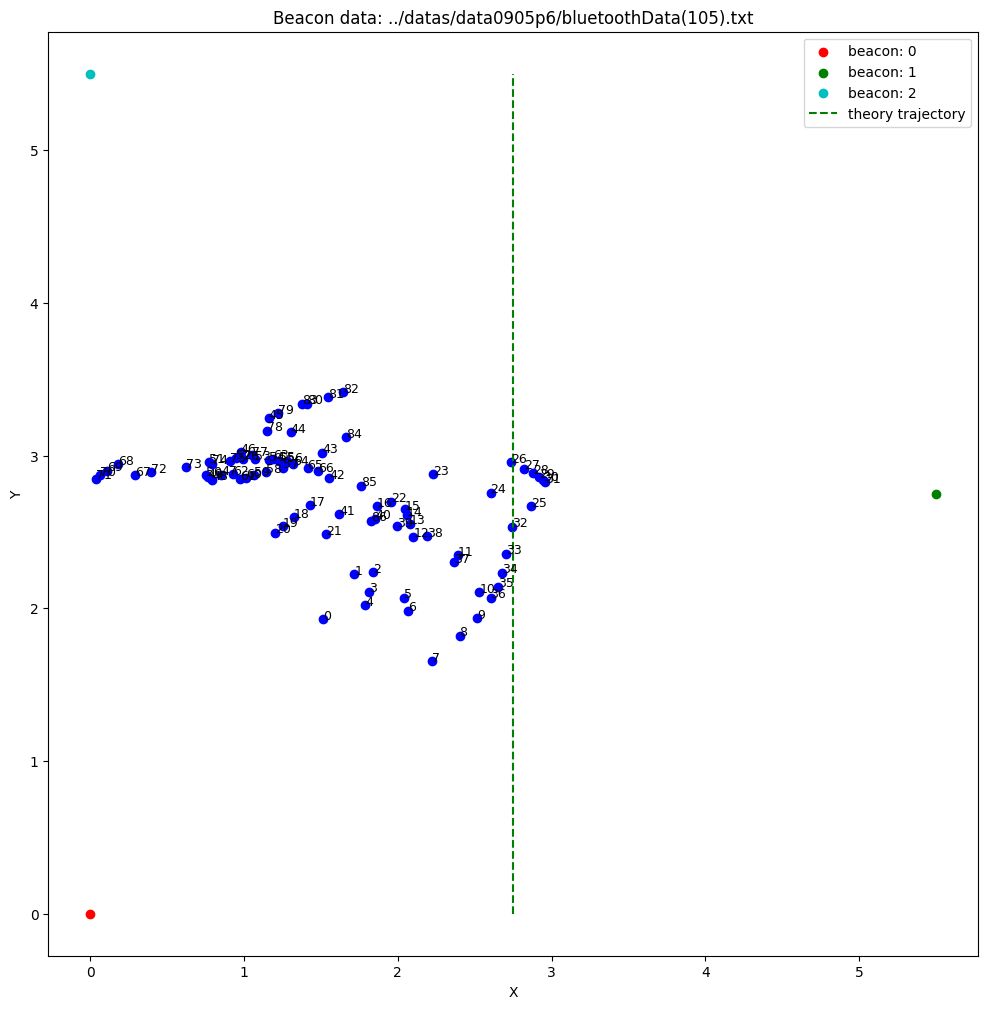

positions [array([[1.51182679],
       [1.92978595],
       [0.81891898]]), array([[1.71644418],
       [2.22192749],
       [0.86168518]]), array([[1.84013839],
       [2.23558176],
       [0.88122798]]), array([[1.81255049],
       [2.10885426],
       [0.8933898 ]]), array([[1.7894219 ],
       [2.02059272],
       [0.90075094]]), array([[2.04220667],
       [2.06863882],
       [0.90480189]]), array([[2.06756442],
       [1.98346143],
       [0.90678124]]), array([[2.22424316],
       [1.65181142],
       [0.90756517]]), array([[2.40107525],
       [1.81951796],
       [0.90768949]]), array([[2.51449147],
       [1.93496467],
       [0.90746604]]), array([[2.53006431],
       [2.10361674],
       [0.90706157]]), array([[2.38936117],
       [2.34916989],
       [0.90660084]]), array([[2.09987722],
       [2.46736722],
       [0.90607798]]), array([[2.07663955],
       [2.55341946],
       [0.90557947]]), array([[2.05949447],
       [2.61115267],
       [0.90509322]]), array([[2.0467

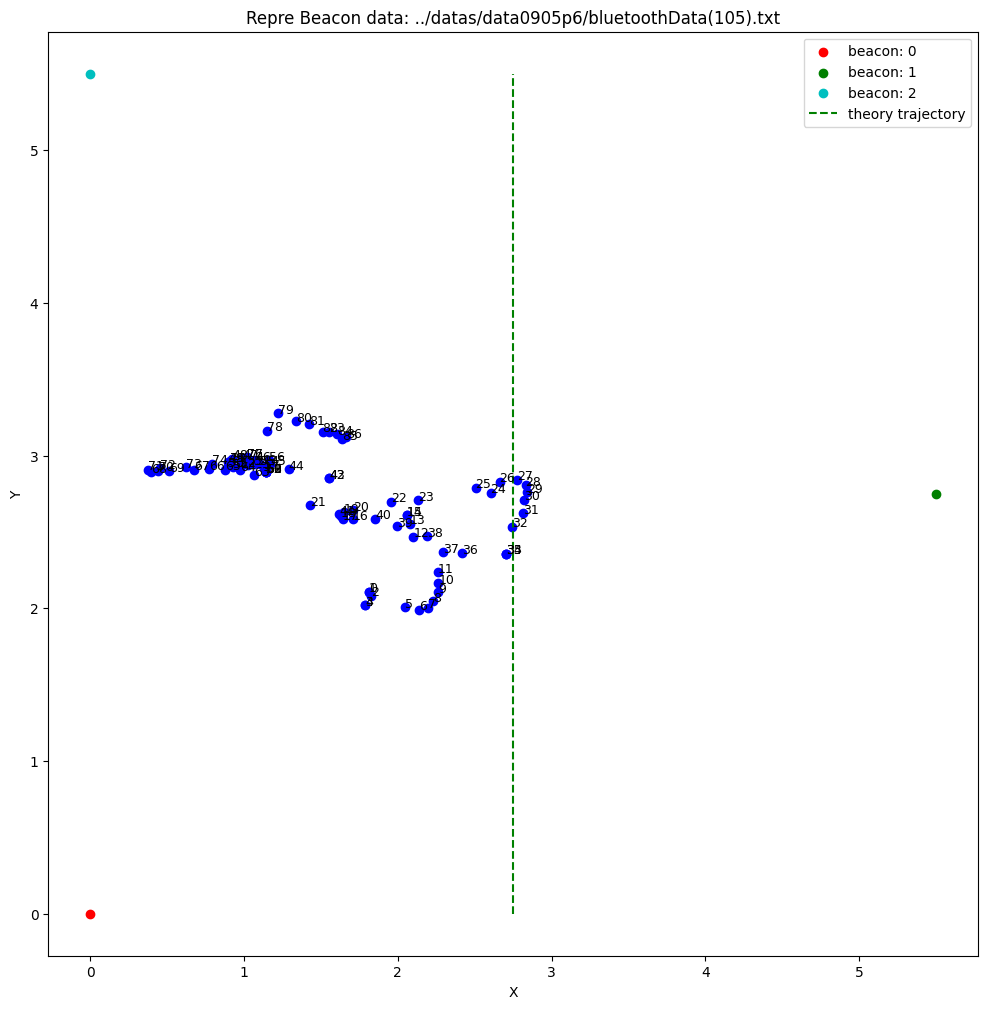

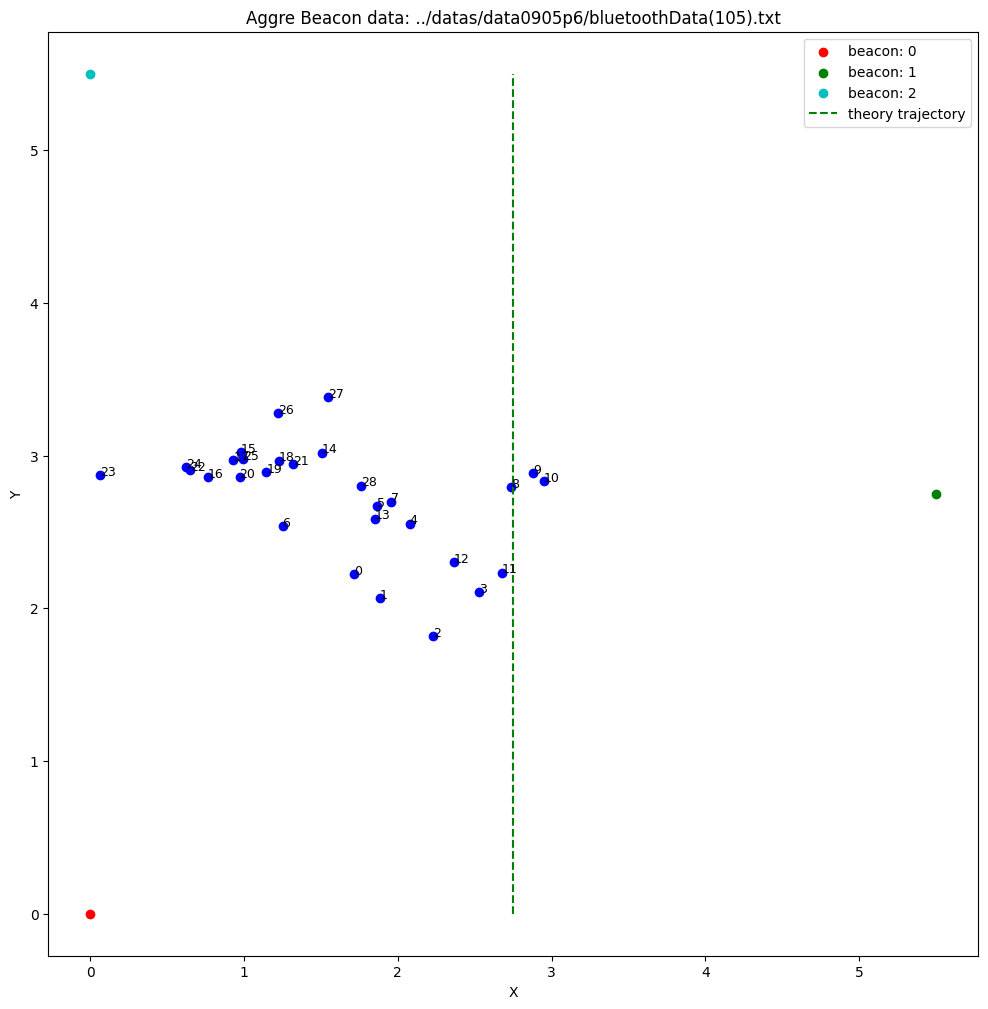

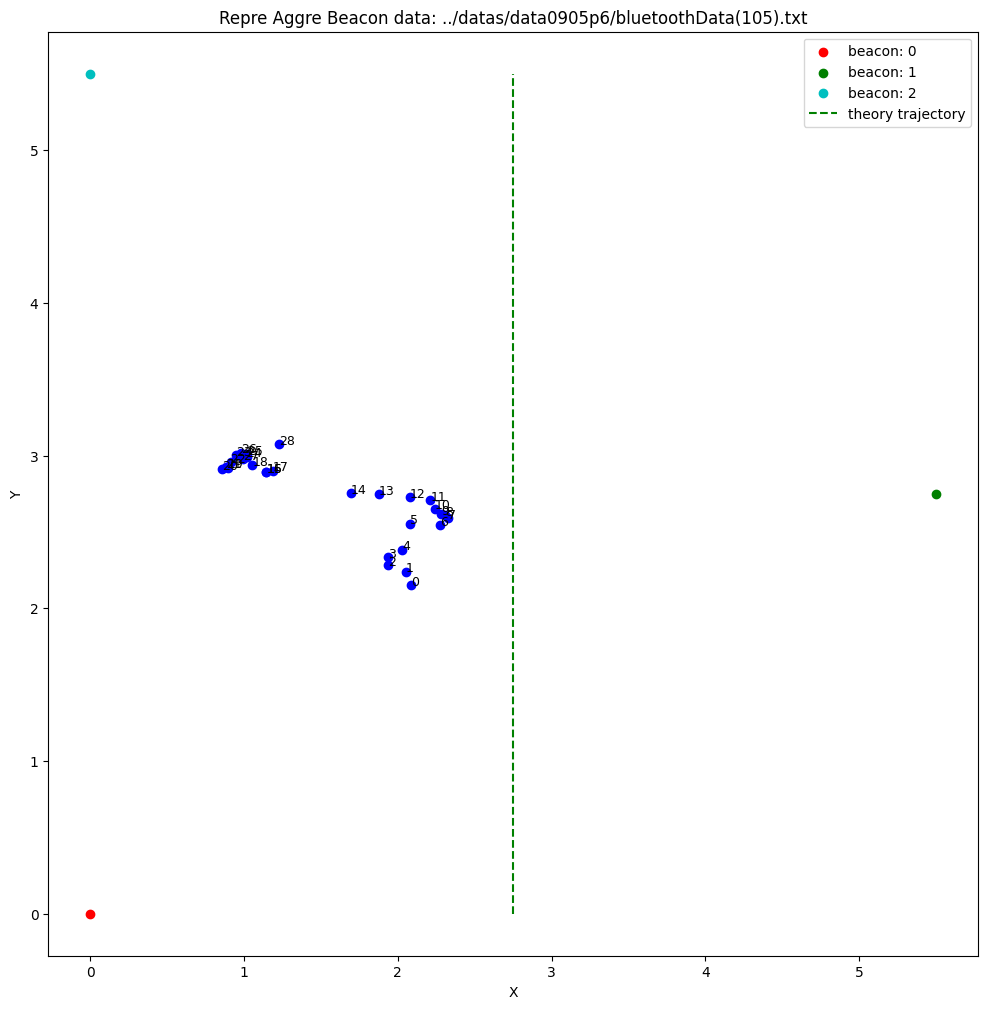

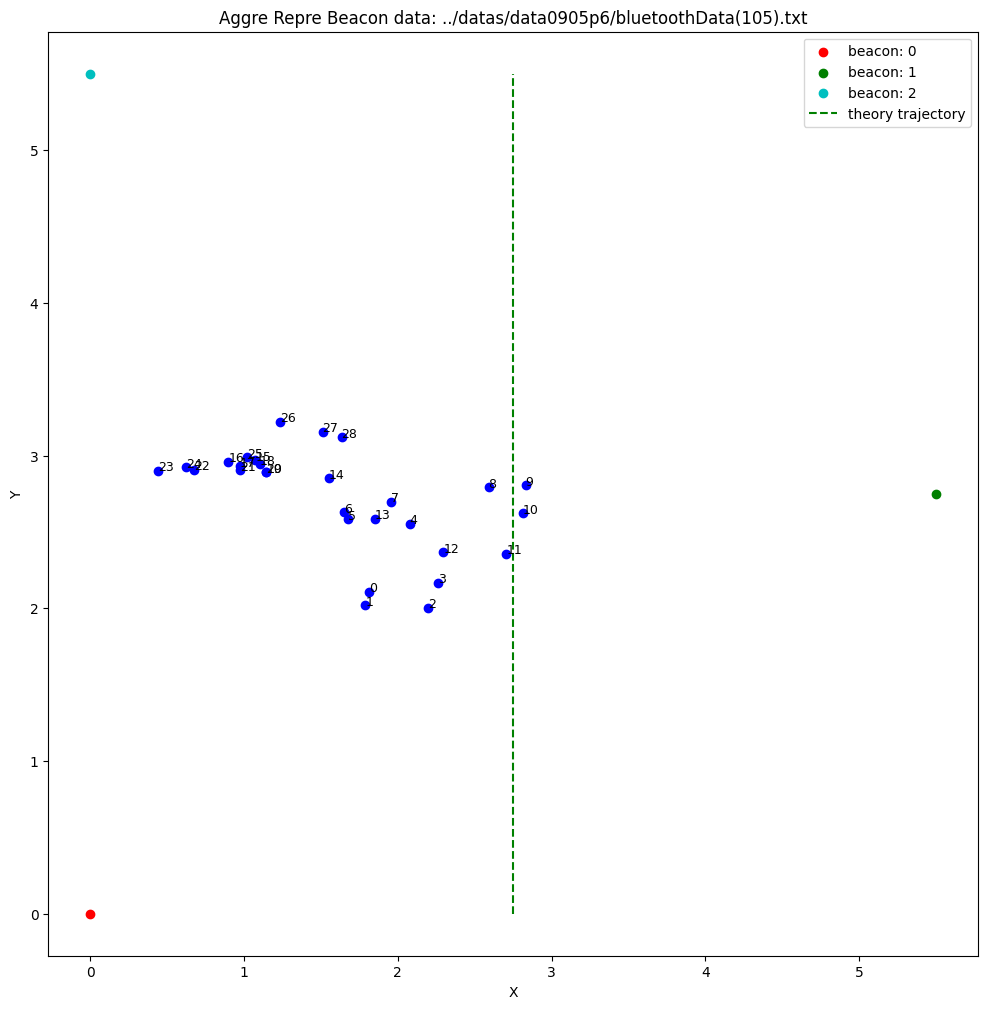

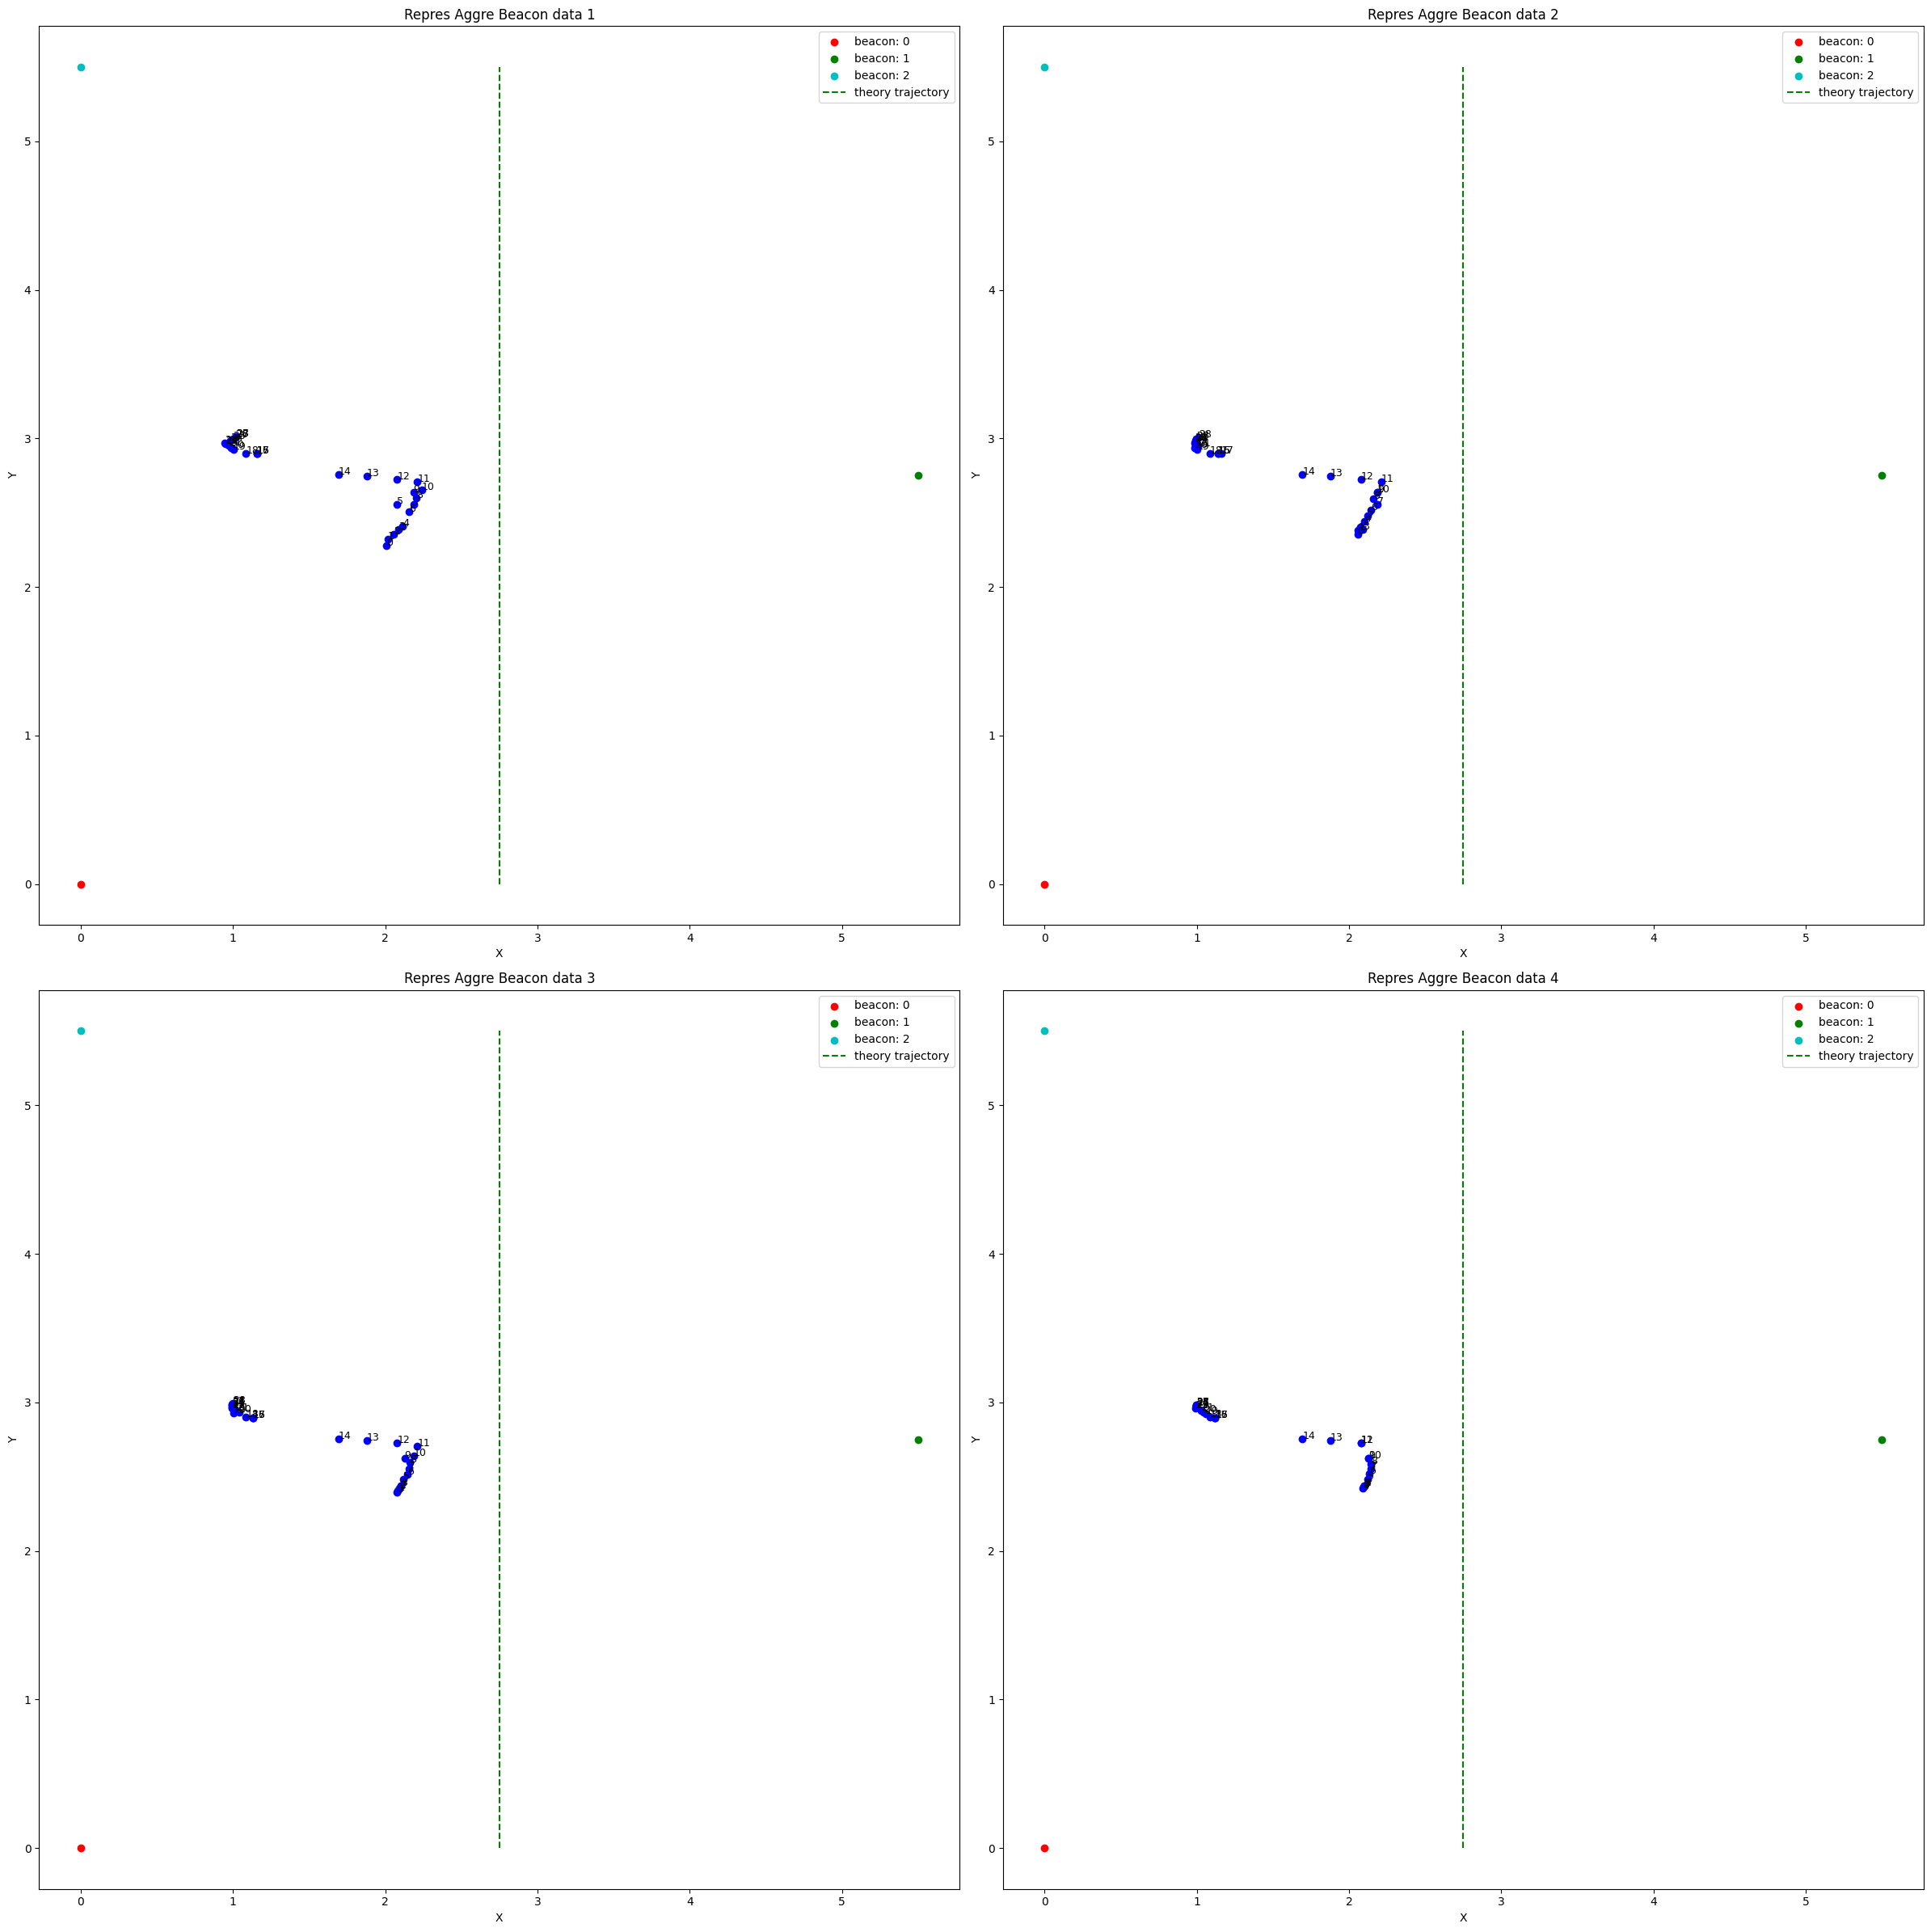

In [10]:

    
for i, positions in enumerate(positionss):
    print("len positions", len(positions))
    args.beacon_data_file = args.beacon_data_dir + files[i]
    actual_coords = read_beacon_coords(args.beacon_coords_file)
    
    colors = ['r', 'g', 'c', 'm', 'y', 'k', 'b']
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
        
    print("positions", positions)
    for i, pos in enumerate(positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
        
    plt.vlines(2.75, 0, 5.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Beacon data: {args.beacon_data_file}")
    plt.show()

    print("positions", positions)
    
    repre_size = 8
    aggre_size = 3
    
    repre_positions = aggregate_continuous_points_sliding(positions, repre_size)
    aggre_positinons = aggregate_continuous_points(positions, aggre_size)
    repre_aggre_positions = aggregate_continuous_points_sliding(aggre_positinons, repre_size)
    aggre_repre_positions = aggregate_continuous_points(repre_positions, aggre_size)
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(repre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    
    plt.vlines(2.75, 0, 5.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Repre Beacon data: {args.beacon_data_file}")
    plt.show()


    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(aggre_positinons):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    
    plt.vlines(2.75, 0, 5.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Aggre Beacon data: {args.beacon_data_file}")
    plt.show()
    
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(repre_aggre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    plt.vlines(2.75, 0, 5.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Repre Aggre Beacon data: {args.beacon_data_file}")
    plt.show()
    
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(aggre_repre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    plt.vlines(2.75, 0, 5.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Aggre Repre Beacon data: {args.beacon_data_file}")
    plt.show()
    
    repres_aggre_positions = []
    repre_num = 4
    temp_repre_positions = repre_aggre_positions
    for i in range(repre_num):
        temp_repre_positions = aggregate_continuous_points_sliding(temp_repre_positions, repre_size)
        repres_aggre_positions.append(temp_repre_positions)
    
    plt.figure(figsize=(24, 24))
    for idx, repres_aggre_pos in enumerate(repres_aggre_positions):
        plt.subplot(2, 2, idx + 1)
        for i, k in enumerate(actual_coords.keys()):
            plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
        for i, pos in enumerate(repres_aggre_pos):
            if pos is None:
                continue
            plt.scatter(pos[0], pos[1], c='b')
            plt.text(pos[0], pos[1], f"{i}", fontsize=9)
        plt.vlines(2.75, 0, 5.5, colors='g', linestyles='dashed', label='theory trajectory')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title(f"Repres Aggre Beacon data {idx + 1}")
    plt.tight_layout()
    plt.show()
    


In [11]:
def calculate_mae(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    return np.mean(np.abs(actual_coords - estimated_coords))

def calculate_rmse(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    return np.sqrt(np.mean((actual_coords - estimated_coords) ** 2))

def calculate_rmse1(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    distances = np.linalg.norm(actual_coords - estimated_coords, axis=1)
    return np.sqrt(np.mean((distances) ** 2))

def calculate_average_distance(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    return np.mean(np.sqrt(np.sum((actual_coords - estimated_coords) ** 2, axis=1)))

v = 5.5*100//total_interval
for i, positions in enumerate(positionss):
    actual_coords = [[2.75, v*j, 0.9] for j in range(len(positions))]
    repre_positions = aggregate_continuous_points_sliding(positions, 8)
    aggre_positinons = aggregate_continuous_points(positions, 3)
    
    repre_positions = np.array(repre_positions)
    actual_coords = np.array(actual_coords)
    actual_coords = actual_coords[:,:, np.newaxis]
    
    print("shapes", np.array(actual_coords).shape, np.array(positions).shape, np.array(repre_positions).shape, np.array(aggre_positinons).shape)
    
    print("actual_coords", actual_coords[-10:])
    print("MAE for file: ", files[i])
    print("MAE for actual_coords: ", calculate_mae(actual_coords, positions))
    print("MAE for repre_positions: ", calculate_mae(actual_coords, repre_positions))
    print("RMSE for actual_coords: ", calculate_rmse(actual_coords, positions))
    print("RMSE for repre_positions: ", calculate_rmse(actual_coords, repre_positions))
    print("RMSE1 for actual_coords: ", calculate_rmse1(actual_coords, positions))
    print("RMSE1 for repre_positions: ", calculate_rmse1(actual_coords, repre_positions))
    print("Average distance for actual_coords: ", calculate_average_distance(actual_coords, positions))
    print("Average distance for repre_positions: ", calculate_average_distance(actual_coords, repre_positions))



# plt.figure(figsize=(12, 12))
# plt.plot(actual_coords[:, 0], actual_coords[:, 1], 'bo-', label='Actual Trajectory')
# plt.plot(estimated_coords[:, 0], estimated_coords[:, 1], 'ro-', label='Estimated Trajectory')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.title('Actual vs Estimated Trajectory')
# plt.show()

shapes (88, 3, 1) (88, 3, 1) (88, 3, 1) (30, 3, 1)
actual_coords [[[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]]
MAE for file:  bluetoothData(108).txt
MAE for actual_coords:  1.0665816397379944
MAE for repre_positions:  1.0127768413861566
RMSE for actual_coords:  1.697943628801023
RMSE for repre_positions:  1.6488346428198664
RMSE1 for actual_coords:  2.940924633471242
RMSE1 for repre_positions:  2.8558653746436913
Average distance for actual_coords:  2.6719897441040983
Average distance for repre_positions:  2.557807149592613
shapes (88, 3, 1) (88, 3, 1) (88, 3, 1) (30, 3, 1)
actual_coords [[[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  ]
  [0.9 ]]

 [[2.75]
  [0.  

In [12]:
# # visualize the beacon RSSI to distance
# import matplotlib.pyplot as plt
# import numpy as np
# from collections import defaultdict
# import pdb


# def rssi_to_distance(rssi):
#     txPower = -55.47
#     n = 3.106
#     return 10 ** ((txPower - rssi) / (10 * n))

# beacon_id_to_rssi = defaultdict(list)
# time_stamp = []
# print(beacon_data)
# for beacon_group in beacon_data:
#     if len(beacon_group) < 3:
#         print("beacon group length is less than 3")
#         continue
#     for beacon in beacon_group:
#         beacon_id = beacon['uuid']
#         beacon_id_to_rssi[beacon_id].append(beacon['rssi'])
#     time_stamp.append(beacon['time'])

    
# for beacon_id, rssi_values in beacon_id_to_rssi.items():
#     if len(beacon_group[0]) <= 3:
#         print("beacon group length is less than 3")
#         continue
#     plt.figure(figsize=(12, 12))
#     distance = [rssi_to_distance(rssi) for rssi in rssi_values]
#     plt.plot(time_stamp, rssi_values, label='rssi to distance')
#     plt.xlabel('time(s)')
#     plt.ylabel('rssi')
#     plt.legend()
#     plt.title('beacon id: {}'.format(beacon_id))
#     plt.show()
    
#     plt.figure(figsize=(12, 12))
#     plt.plot(time_stamp, distance, label='rssi to distance')
#     plt.xlabel('time(s)')
#     plt.ylabel('distance(m)')
#     plt.title('beacon id: {}'.format(beacon_id))
#     plt.legend()
#     plt.show()
